In [98]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')


# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from scipy.stats import spearmanr, pearsonr
from collections import Counter

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path


In [3]:
#funtion from https://github.com/greenelab/sc_bulk_ood/blob/main/evaluation_experiments/pbmc/pbmc_experiment_perturbation.ipynb
def mean_sqr_error(single1, single2):
  return np.mean((single1 - single2)**2)

In [4]:
def make_prop_table(adata, obs):
    num_cell_counter = Counter(adata.obs[obs])
    num_cells = list()
    cell_types = list()
    prop_cells = list()
    tot_count = 0
    tot_prop = 0

    for cell in num_cell_counter:
        num_cells.append(num_cell_counter[cell])
        cell_types.append(cell)
        tot_count = tot_count + num_cell_counter[cell]

    for cell in num_cell_counter:
        proportion = num_cell_counter[cell] / tot_count
        prop_cells.append(proportion)
        tot_prop = tot_prop + proportion

    cell_types.append('Total')
    num_cells.append(tot_count)
    prop_cells.append(tot_prop)
    table = {'Cell_Types': cell_types, 
        'Num_Cells': num_cells, 
        'Prop_Cells': prop_cells}
    table = pd.DataFrame(table)
    print(tabulate(table,  headers='keys', tablefmt='fancy_grid', showindex = True))
    return table    

In [5]:
#results paths:
path = os.getcwd()
processed_path = f"{path}/../data/mouse_kidney/processed/"

In [6]:
#scanpy config.
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.7.8 umap==0.5.3 numpy==1.19.5 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0 python-igraph==0.9.11 louvain==0.8.0 pynndescent==0.5.8


Importing both datasets SN, SC and Bulk from same mouse:

In [7]:
#reading in the combined data (normalized separately) processed in R Seurat
sn_path = f"{path}/../data/mouse_kidney/GSE141115_withnames/M7_SN_FANS_3×500g.txt.gz"
sn_adata = sc.read_text(sn_path)
sn_adata

AnnData object with n_obs × n_vars = 16524 × 8611

In [8]:
sc_path = f"{path}/../data/mouse_kidney/GSE141115_withnames/M7_SC_ColdDiss_Fresh.txt.gz"
sc_adata = sc.read_text(sc_path)
sc_adata

AnnData object with n_obs × n_vars = 14310 × 4606

In [9]:
bulk_path = f"{path}/../data/mouse_kidney/GSE141115_withnames/M7_BulkSeq_ColdDiss_Fresh.txt.gz"
bulk_adata = sc.read_text(bulk_path, delimiter=None)
bulk_adata

AnnData object with n_obs × n_vars = 29071 × 1

In [10]:
#all datasets need transposing:
sn_adata = sn_adata.transpose()
sc_adata = sc_adata.transpose()
bulk_adata = bulk_adata.transpose()

In [12]:
sn_adata.var_names_make_unique()
sc_adata.var_names_make_unique()  

Assigning cell types to each:

In [13]:
#importing the paper's excel sheet with cell types:
cell_path = f"{path}/../data/mouse_kidney/cell_assignments/13059_2020_2048_MOESM3_ESM.xlsx"
cell_assign_sn = pd.read_excel(cell_path, sheet_name = 'cells_and_nuclei_v2_chemistry')
cell_assign_sn

Unnamed: 0 Library           Protocol Cell type
0      MJ03_BG70_AAACCTGAGCTGCAAG    MJ03              SC_v2        PT
1      MJ03_BG70_AAACCTGAGCTGCGAA    MJ03              SC_v2        PT
2      MJ03_BG70_AAACCTGCAAGTACCT    MJ03              SC_v2        PT
3      MJ03_BG70_AAACGGGAGATCCGAG    MJ03              SC_v2        PT
4      MJ03_BG70_AAACGGGAGATGAGAG    MJ03              SC_v2        PT
...                           ...     ...                ...       ...
32997    MJ08_SN_TTTGTCACATCGGGTC    MJ08  SN_FANS_3x500g_v2      aLOH
32998    MJ08_SN_TTTGTCAGTAGCAAAT    MJ08  SN_FANS_3x500g_v2        PT
32999    MJ08_SN_TTTGTCAGTCCAGTGC    MJ08  SN_FANS_3x500g_v2        PT
33000    MJ08_SN_TTTGTCAGTTACTGAC    MJ08  SN_FANS_3x500g_v2        PT
33001    MJ08_SN_TTTGTCATCGAGGTAG    MJ08  SN_FANS_3x500g_v2      aLOH

[33002 rows x 4 columns]

In [14]:
cell_assign_sc = pd.read_excel(cell_path, sheet_name = 'cells_and_nuclei_v3_chemistry')
cell_assign_sc

Unnamed: 0 Library       Protocol Cell type
0      LD01_SC_FRESH_AAACCCACAACCACAT    LD01          SC_v3     CD_IC
1      LD01_SC_FRESH_AAACCCAGTATGACAA    LD01          SC_v3     CD_IC
2      LD01_SC_FRESH_AAACCCAGTTCAAGGG    LD01          SC_v3       CNT
3      LD01_SC_FRESH_AAACCCATCAGCTTCC    LD01          SC_v3        PT
4      LD01_SC_FRESH_AAACCCATCCTTTGAT    LD01          SC_v3     CD_PC
...                               ...     ...            ...       ...
95670      MJ59_SN_O_TTTGTTGCACCCTCTA    MJ59  SN_sucrose_v3      aLOH
95671      MJ59_SN_O_TTTGTTGCAGCATTGT    MJ59  SN_sucrose_v3        MC
95672      MJ59_SN_O_TTTGTTGGTAGCTGCC    MJ59  SN_sucrose_v3        PT
95673      MJ59_SN_O_TTTGTTGGTGTTAACC    MJ59  SN_sucrose_v3        PT
95674      MJ59_SN_O_TTTGTTGGTTGCCGCA    MJ59  SN_sucrose_v3        PT

[95675 rows x 4 columns]

In [15]:
sn_celltypes = cell_assign_sn[cell_assign_sn['Library']=='MJ06']
sn_celltypes

Unnamed: 0 Library           Protocol Cell type
9153   MJ06_SN_AAACCTGAGATCCCGC    MJ06  SN_FANS_3x500g_v2      aLOH
9154   MJ06_SN_AAACCTGAGCCACTAT    MJ06  SN_FANS_3x500g_v2      aLOH
9155   MJ06_SN_AAACCTGAGCGTGAAC    MJ06  SN_FANS_3x500g_v2      aLOH
9156   MJ06_SN_AAACCTGAGTACGCGA    MJ06  SN_FANS_3x500g_v2        PT
9157   MJ06_SN_AAACCTGCAACACCTA    MJ06  SN_FANS_3x500g_v2      aLOH
...                         ...     ...                ...       ...
17759  MJ06_SN_TTTGTCAGTGCAACGA    MJ06  SN_FANS_3x500g_v2        PT
17760  MJ06_SN_TTTGTCAGTTCCATGA    MJ06  SN_FANS_3x500g_v2      aLOH
17761  MJ06_SN_TTTGTCATCCTACAGA    MJ06  SN_FANS_3x500g_v2        PT
17762  MJ06_SN_TTTGTCATCGCGATCG    MJ06  SN_FANS_3x500g_v2        PT
17763  MJ06_SN_TTTGTCATCTGACCTC    MJ06  SN_FANS_3x500g_v2      aLOH

[8611 rows x 4 columns]

In [16]:
sn_celltypes['Cell type']

9153     aLOH
9154     aLOH
9155     aLOH
9156       PT
9157     aLOH
         ... 
17759      PT
17760    aLOH
17761      PT
17762      PT
17763    aLOH
Name: Cell type, Length: 8611, dtype: object

In [17]:
sn_adata.obs['cell_type'] = sn_celltypes['Cell type'].values
sn_adata.obs

cell_type
MJ06_SN_AAACCTGAGATCCCGC      aLOH
MJ06_SN_AAACCTGAGCCACTAT      aLOH
MJ06_SN_AAACCTGAGCGTGAAC      aLOH
MJ06_SN_AAACCTGAGTACGCGA        PT
MJ06_SN_AAACCTGCAACACCTA      aLOH
...                            ...
MJ06_SN_TTTGTCAGTGCAACGA        PT
MJ06_SN_TTTGTCAGTTCCATGA      aLOH
MJ06_SN_TTTGTCATCCTACAGA        PT
MJ06_SN_TTTGTCATCGCGATCG        PT
MJ06_SN_TTTGTCATCTGACCTC      aLOH

[8611 rows x 1 columns]

In [18]:
#now assigning sc cell types
sc_celltypes = cell_assign_sc[cell_assign_sc['Library']=='LD01']
sc_celltypes

Unnamed: 0 Library Protocol Cell type
0     LD01_SC_FRESH_AAACCCACAACCACAT    LD01    SC_v3     CD_IC
1     LD01_SC_FRESH_AAACCCAGTATGACAA    LD01    SC_v3     CD_IC
2     LD01_SC_FRESH_AAACCCAGTTCAAGGG    LD01    SC_v3       CNT
3     LD01_SC_FRESH_AAACCCATCAGCTTCC    LD01    SC_v3        PT
4     LD01_SC_FRESH_AAACCCATCCTTTGAT    LD01    SC_v3     CD_PC
...                              ...     ...      ...       ...
4601  LD01_SC_FRESH_TTTGTTGGTGAGATCG    LD01    SC_v3        PT
4602  LD01_SC_FRESH_TTTGTTGGTTTCACAG    LD01    SC_v3       CNT
4603  LD01_SC_FRESH_TTTGTTGTCCCTCGTA    LD01    SC_v3      aLOH
4604  LD01_SC_FRESH_TTTGTTGTCGAGAGAC    LD01    SC_v3      Endo
4605  LD01_SC_FRESH_TTTGTTGTCGAGATGG    LD01    SC_v3        PT

[4606 rows x 4 columns]

In [19]:
sc_adata.obs['cell_type'] = sc_celltypes['Cell type'].values
sc_adata.obs

cell_type
LD01_SC_FRESH_AAACCCACAACCACAT     CD_IC
LD01_SC_FRESH_AAACCCAGTATGACAA     CD_IC
LD01_SC_FRESH_AAACCCAGTTCAAGGG       CNT
LD01_SC_FRESH_AAACCCATCAGCTTCC        PT
LD01_SC_FRESH_AAACCCATCCTTTGAT     CD_PC
...                                  ...
LD01_SC_FRESH_TTTGTTGGTGAGATCG        PT
LD01_SC_FRESH_TTTGTTGGTTTCACAG       CNT
LD01_SC_FRESH_TTTGTTGTCCCTCGTA      aLOH
LD01_SC_FRESH_TTTGTTGTCGAGAGAC      Endo
LD01_SC_FRESH_TTTGTTGTCGAGATGG        PT

[4606 rows x 1 columns]

In [20]:
sn_genes = pd.DataFrame(sn_adata.var) 
sc_genes = pd.DataFrame(sc_adata.var)
bulk_genes = pd.DataFrame(bulk_adata.var)
sn_genes = sn_genes.transpose()
sc_genes = sc_genes.transpose()
bulk_genes = bulk_genes.transpose()

In [25]:
common_genes = np.intersect1d(sc_genes.columns, sn_genes.columns)
common_genes= list(common_genes)
common_genes

['0610007P14Rik',
 '0610009B22Rik',
 '0610009L18Rik',
 '0610009O20Rik',
 '0610010F05Rik',
 '0610010K14Rik',
 '0610011F06Rik',
 '0610012G03Rik',
 '0610025J13Rik',
 '0610030E20Rik',
 '0610033M10Rik',
 '0610037L13Rik',
 '0610038B21Rik',
 '0610040B10Rik',
 '0610040F04Rik',
 '0610040J01Rik',
 '0610043K17Rik',
 '1010001B22Rik',
 '1110001J03Rik',
 '1110002L01Rik',
 '1110004E09Rik',
 '1110004F10Rik',
 '1110006O24Rik',
 '1110008F13Rik',
 '1110008L16Rik',
 '1110008P14Rik',
 '1110012L19Rik',
 '1110019D14Rik',
 '1110020A21Rik',
 '1110032A03Rik',
 '1110034G24Rik',
 '1110035H17Rik',
 '1110037F02Rik',
 '1110038F14Rik',
 '1110046J04Rik',
 '1110051M20Rik',
 '1110059E24Rik',
 '1110059G10Rik',
 '1110065P20Rik',
 '1190002N15Rik',
 '1190005I06Rik',
 '1190007I07Rik',
 '1300002E11Rik',
 '1500002C15Rik',
 '1500011B03Rik',
 '1500011K16Rik',
 '1500015A07Rik',
 '1500015O10Rik',
 '1500026H17Rik',
 '1600002H07Rik',
 '1600002K03Rik',
 '1600010M07Rik',
 '1600012H06Rik',
 '1600014C10Rik',
 '1600020E01Rik',
 '1700001L

In [ ]:
common_genes_wbulk = np.intersect1d(common_genes, bulk_genes)
common_genes_wbulk= list(common_genes_wbulk)
common_genes_wbulk

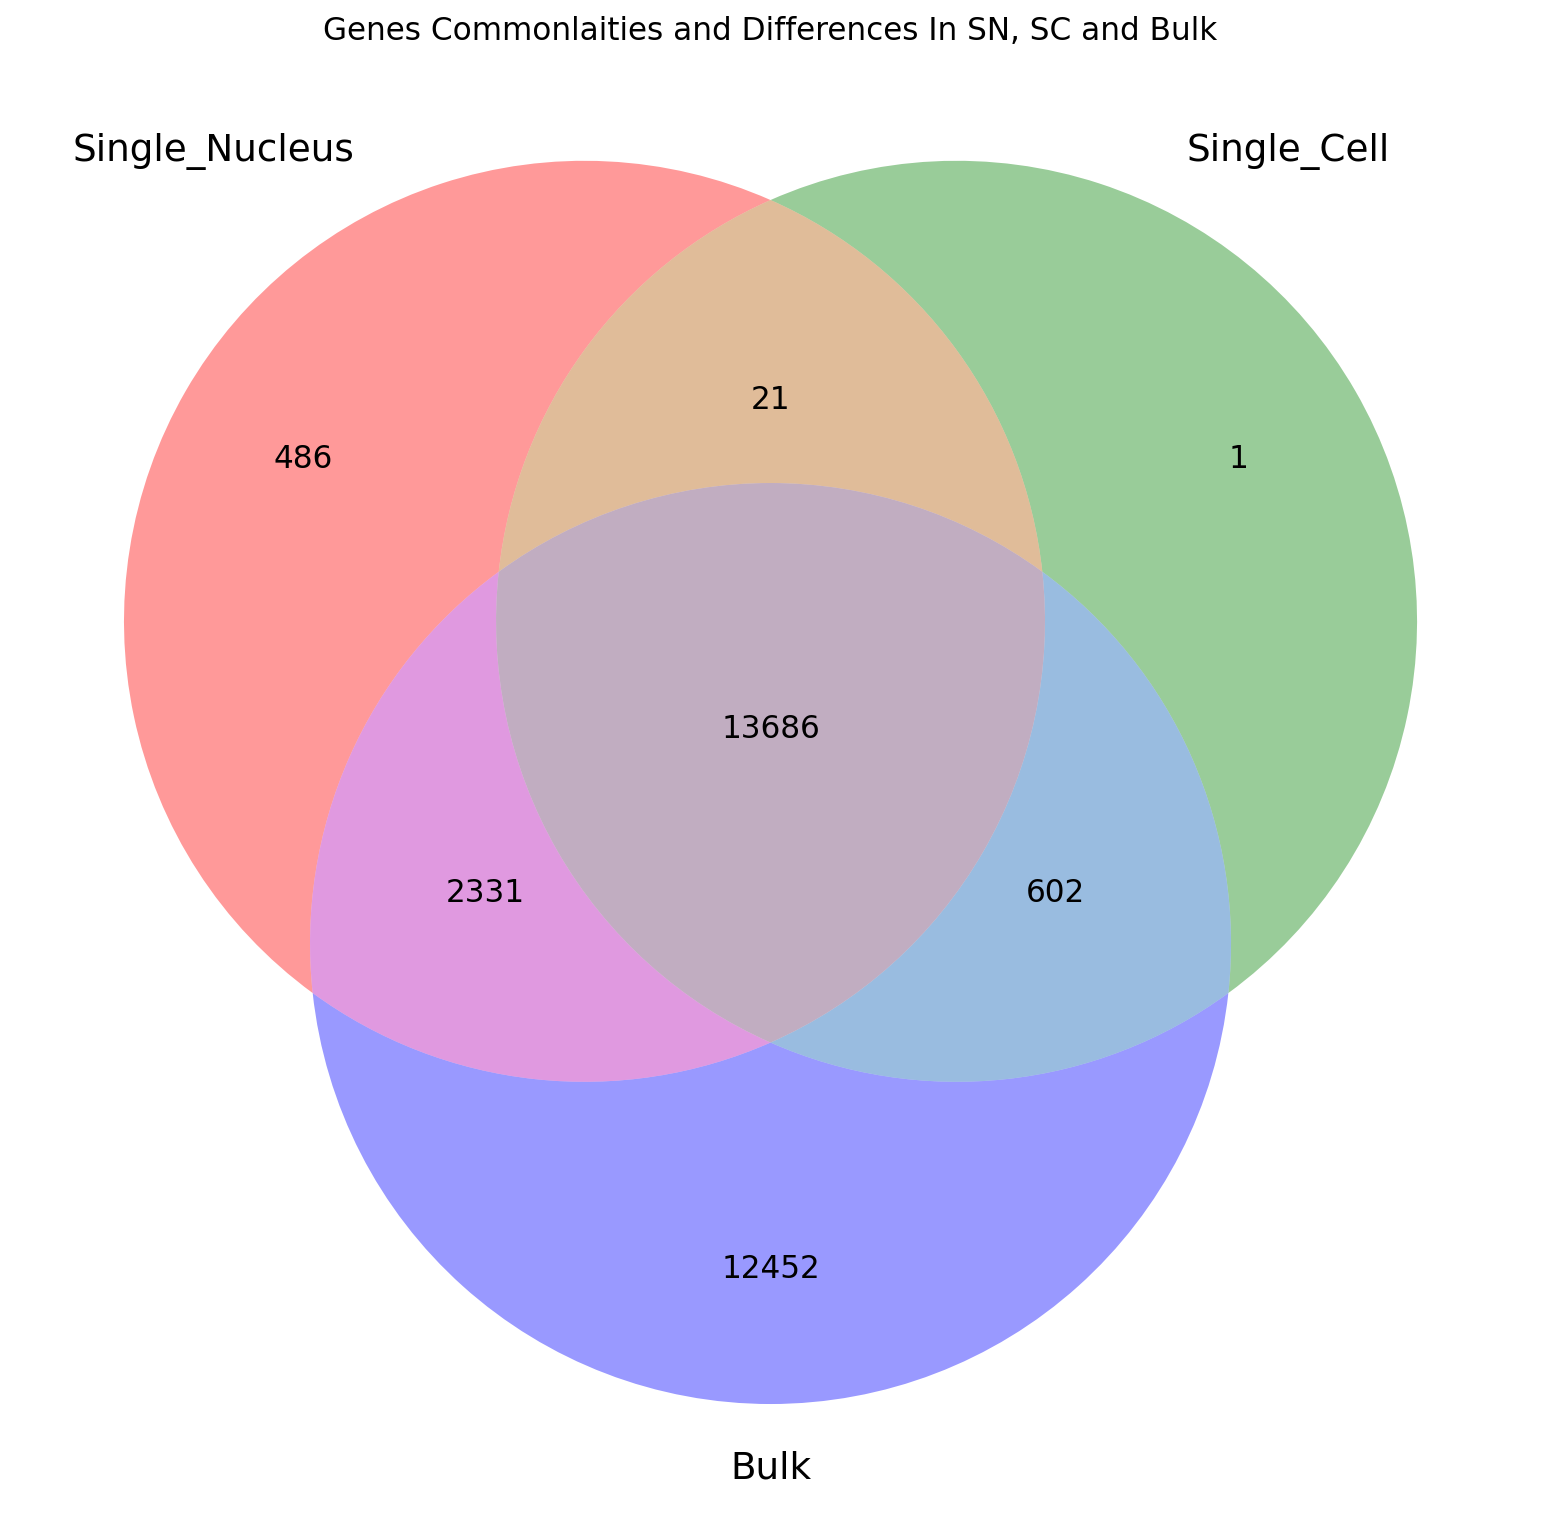

In [27]:
#common genes between SN and Bulk
common_genes_snwbulk = np.intersect1d(sn_genes.columns, bulk_genes.columns)
common_genes_snwbulk = list(common_genes_snwbulk)
#common genes between SC and Bulk
common_genes_scwbulk = np.intersect1d(sc_genes.columns, bulk_genes.columns)
common_genes_scwbulk = list(common_genes_scwbulk)

#common genes between bulk, SN, and SC.
len(common_genes_wbulk)

#common genes between SN and SC only, no bulk.
len(common_genes)

#calculating variables to plot on Venn and see gene discrepancies.
val5 =  len(np.setxor1d(common_genes_wbulk, common_genes_snwbulk))
val6 =  len(np.setxor1d(common_genes_wbulk, common_genes_scwbulk))
val3 = len(common_genes) - len(common_genes_wbulk)
val7 = len(common_genes_wbulk)
val4= bulk_genes.shape[1] - val7 - val5 - val6
val7 = len(common_genes_wbulk)
val1 = sn_genes.shape[1] - val3 - val7 - val5
val2 = sc_genes.shape[1] -  val3 - val7 - val6

#venn diagram for gene discrepancies
plt.figure(figsize=(15,12))  
gene_venn = venn3_unweighted(subsets =(val1, 
                            val2,
                            val3,
                            val4,
                            val5,
                            val6,
                            val7), 
                              set_labels = ('Single_Nucleus', 'Single_Cell', 'Bulk')
                            )
plt.title("Genes Commonlaities and Differences In SN, SC and Bulk")                  
plt.show()

In [28]:
#Code based from https://github.com/scverse/anndata/issues/73 falexwolf commented on Oct 20, 2018
#trimming down the sc_adata to contain only the genes available in common_genes SN and SC
common_gene_indicator = np.in1d(sc_adata.var_names, common_genes)
sc_adata = sc_adata[:, common_gene_indicator]
sc_adata

View of AnnData object with n_obs × n_vars = 4606 × 13707
    obs: 'cell_type'

In [29]:
#Code based from https://github.com/scverse/anndata/issues/73 falexwolf commented on Oct 20, 2018
#trimming down the sn_adta to contain only genes available in common_genes SN and SC
common_gene_indicator = np.in1d(sn_adata.var_names, common_genes)
sn_adata = sn_adata[:, common_gene_indicator]
sn_adata

View of AnnData object with n_obs × n_vars = 8611 × 13707
    obs: 'cell_type'

QCing the single nucleus data first:

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


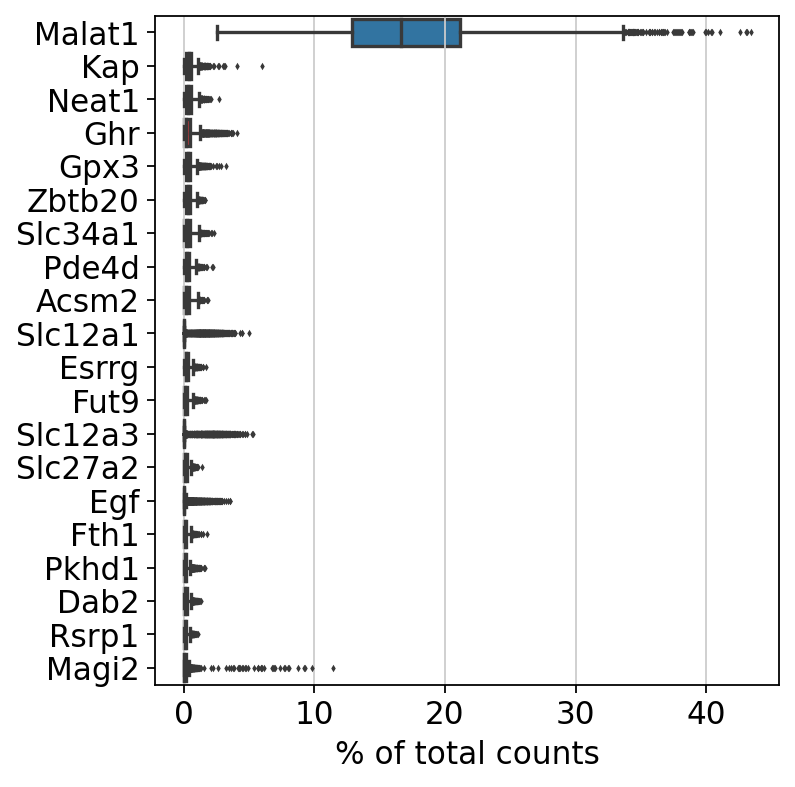

In [30]:
sc.pl.highest_expr_genes(sn_adata, n_top=20, )

In [31]:
sc.pp.filter_cells(sn_adata, min_genes=200)
sc.pp.filter_genes(sn_adata, min_cells=3)

filtered out 425 genes that are detected in less than 3 cells


In [32]:
sn_adata.var['mt'] = sn_adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sn_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


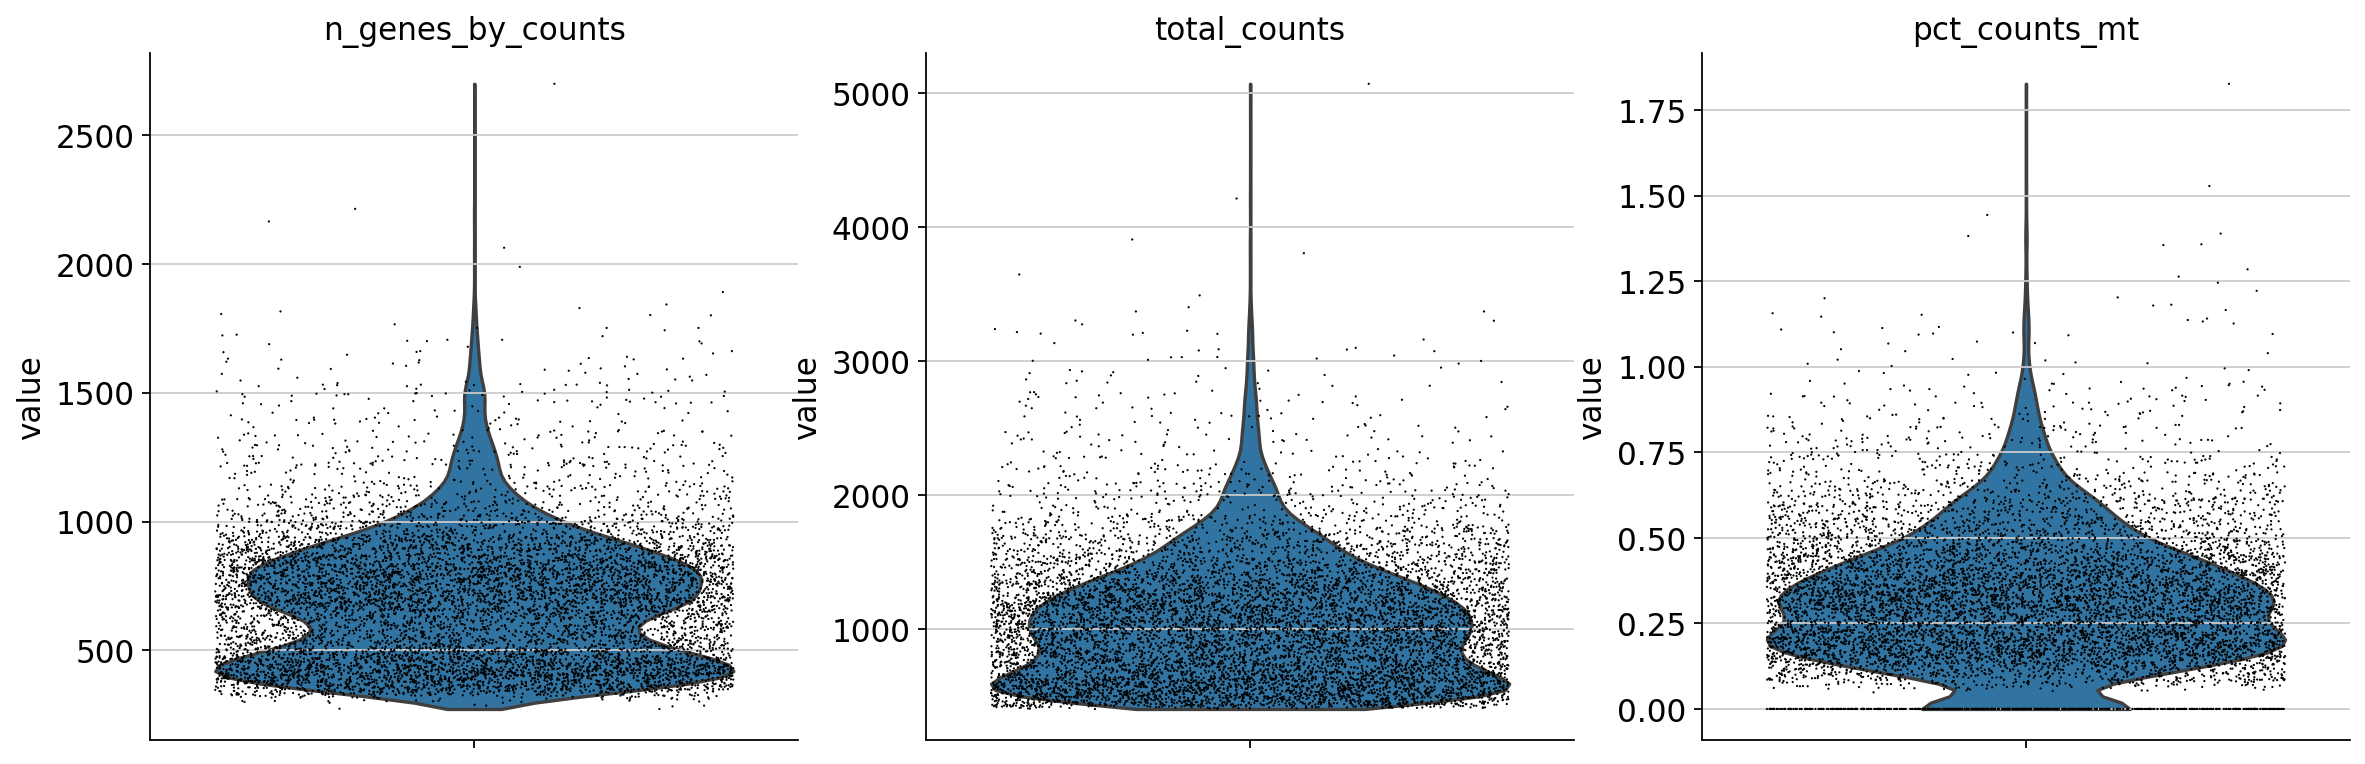

In [33]:
sc.pl.violin(sn_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

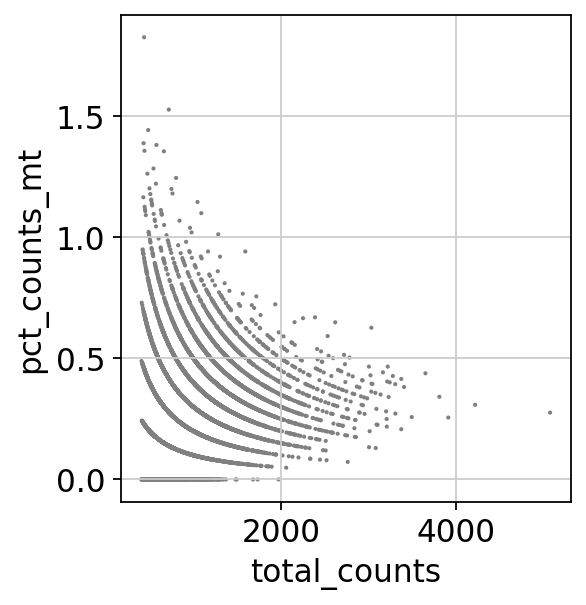

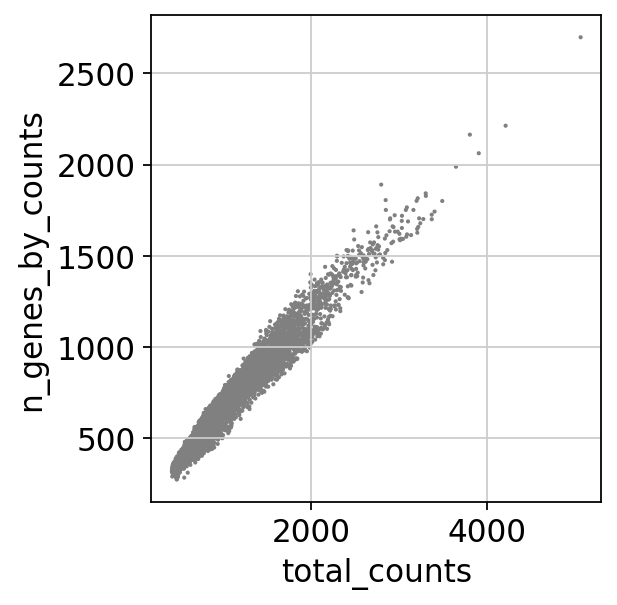

In [34]:
sc.pl.scatter(sn_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sn_adata, x='total_counts', y='n_genes_by_counts')

In [35]:
sn_data = sn_adata[sn_adata.obs.n_genes_by_counts < 2000, :]
sn_adata = sn_adata[sn_adata.obs.pct_counts_mt < 1.5, :]

In [36]:
sn_adata

View of AnnData object with n_obs × n_vars = 8609 × 13282
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [37]:
sc.pp.normalize_total(sn_adata, target_sum=1e4)
sc.pp.log1p(sn_adata)

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [38]:
sc.pp.highly_variable_genes(sn_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


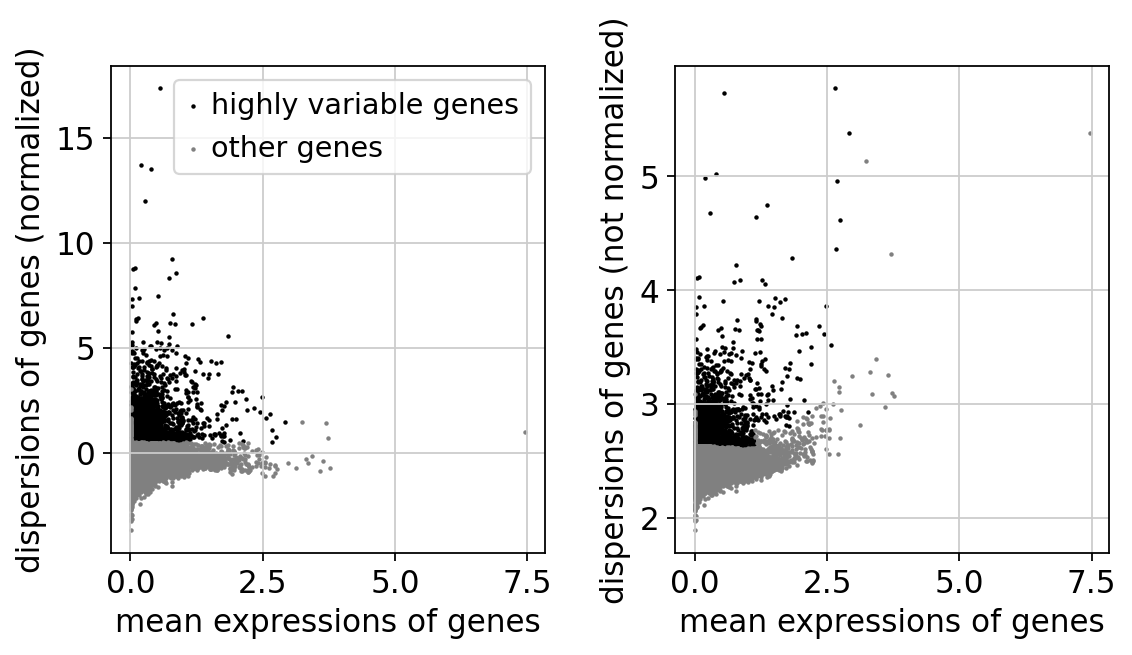

In [39]:
sc.pl.highly_variable_genes(sn_adata)

In [40]:
sn_adata = sn_adata[:, sn_adata.var.highly_variable]

In [41]:
sc.pp.regress_out(sn_adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:32)


In [42]:
sc.pp.scale(sn_adata, max_value=10)

Now QC the single-cell dataset:

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


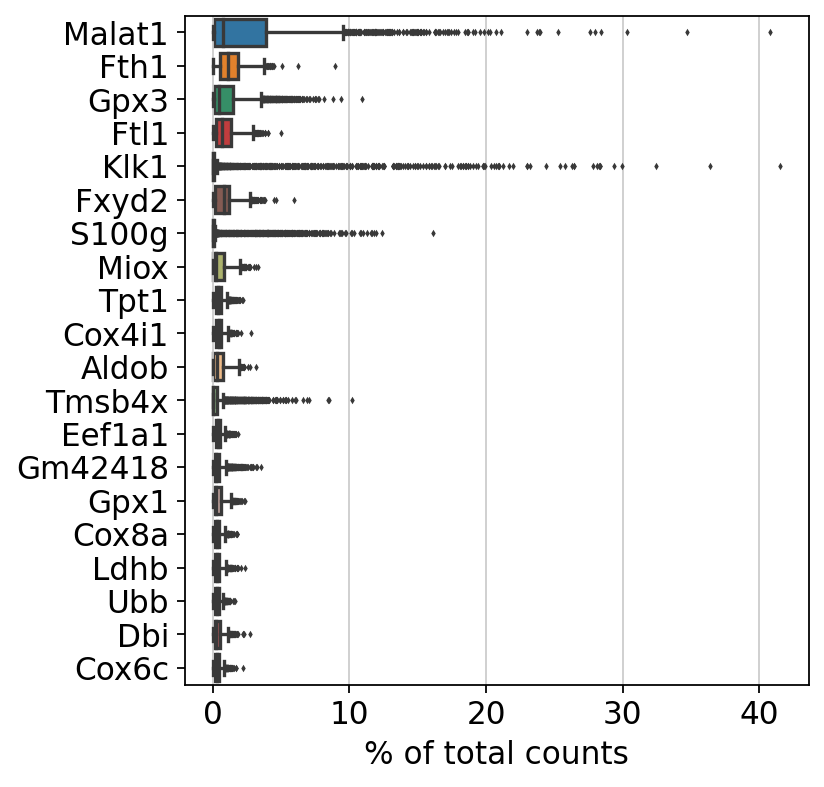

In [43]:
sc.pl.highest_expr_genes(sc_adata, n_top=20, )

In [44]:
sc.pp.filter_cells(sc_adata, min_genes=200)
sc.pp.filter_genes(sc_adata, min_cells=3)

filtered out 16 cells that have less than 200 genes expressed
filtered out 357 genes that are detected in less than 3 cells


In [45]:
sc_adata.var['mt'] = sc_adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


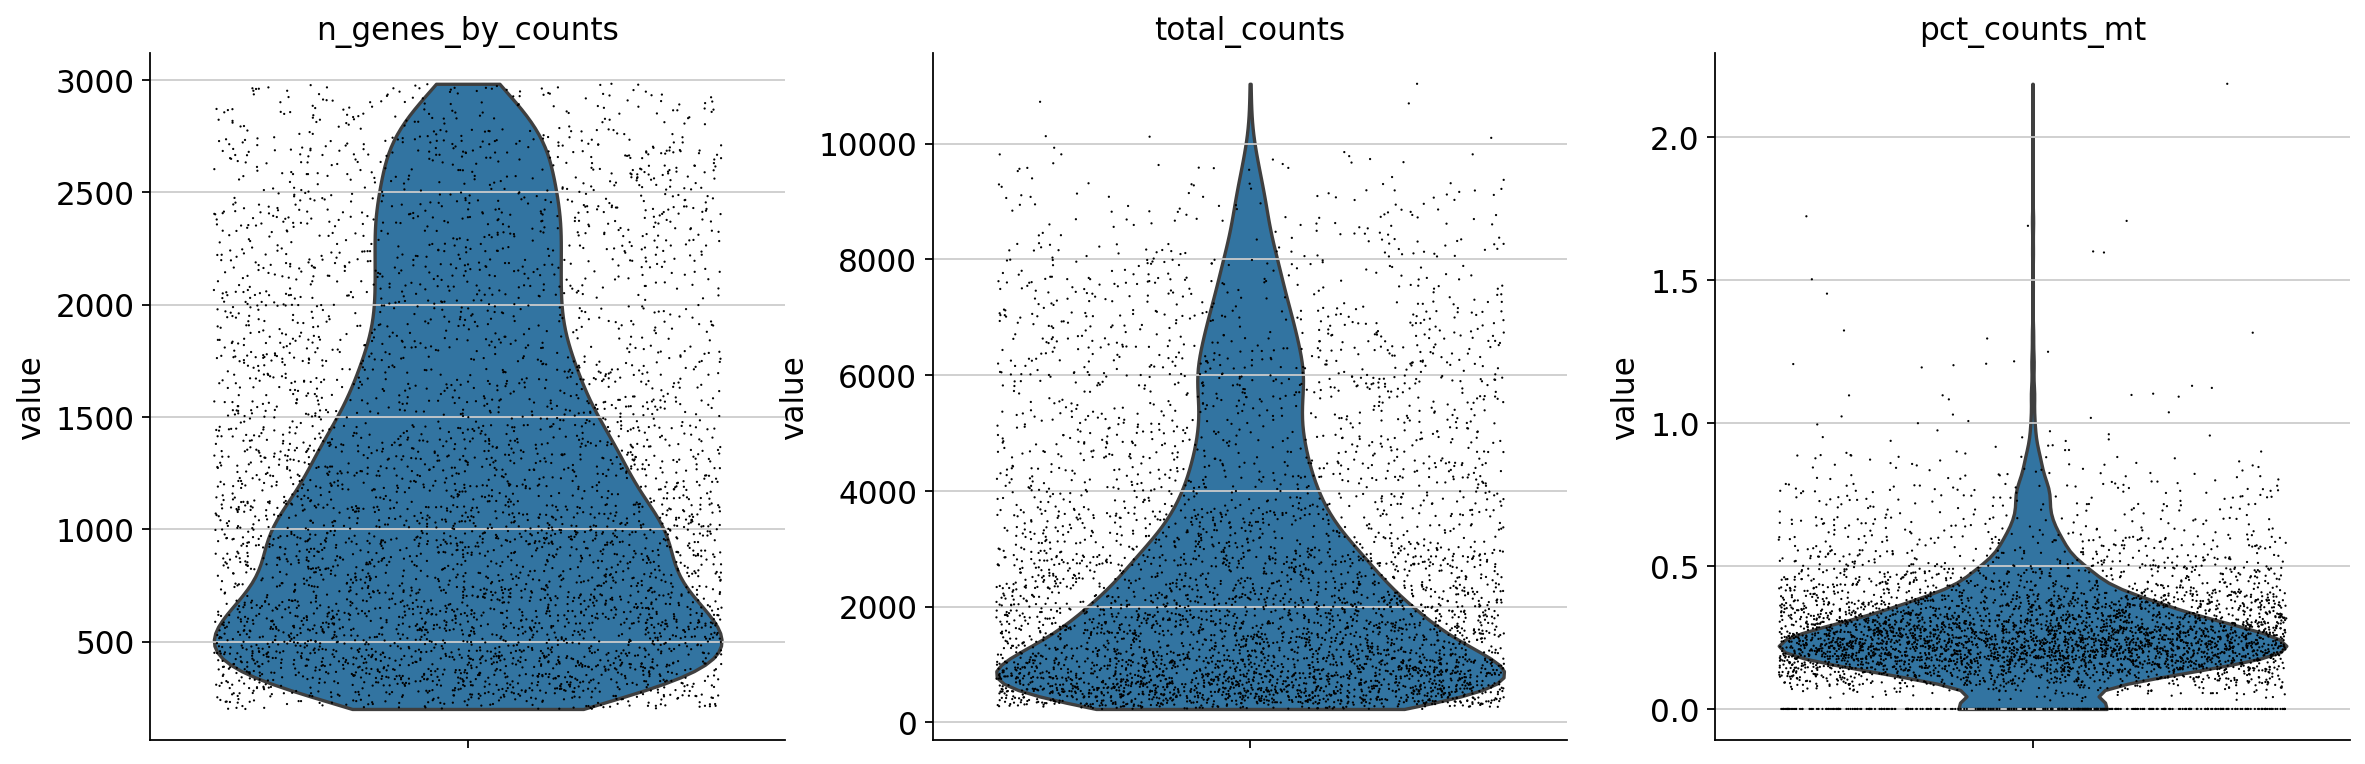

In [46]:
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

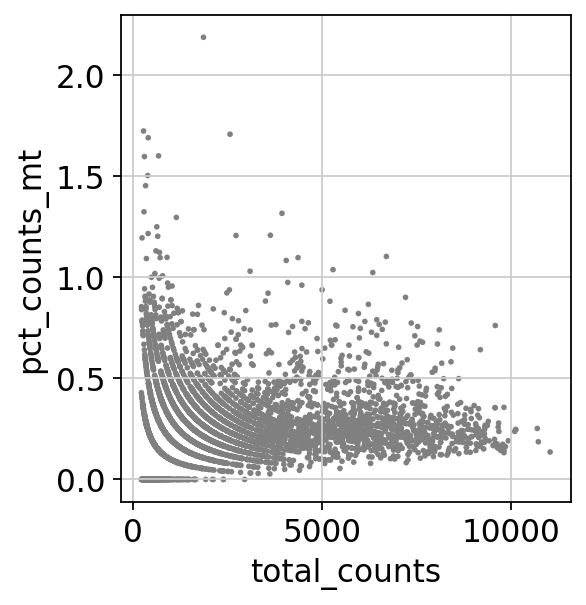

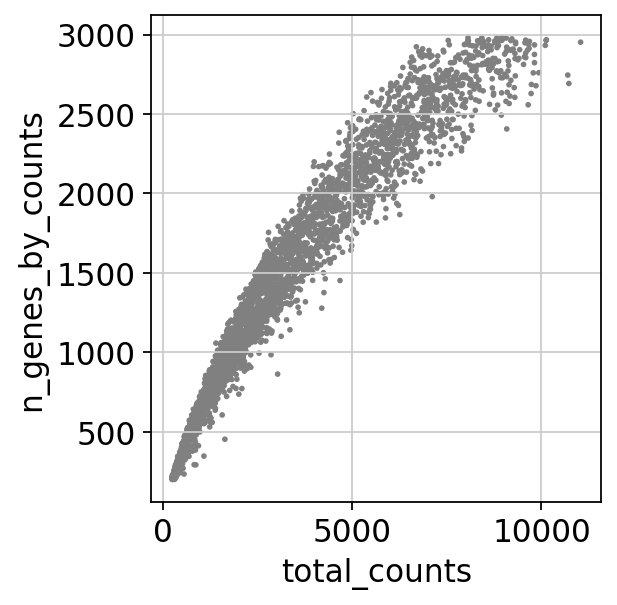

In [47]:
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sc_adata, x='total_counts', y='n_genes_by_counts')

In [48]:
sc_data = sc_adata[sc_adata.obs.n_genes_by_counts < 10000, :]
sc_adata = sc_adata[sc_adata.obs.pct_counts_mt < 1, :]

In [50]:
#normalize and logarize:
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [51]:
sc.pp.highly_variable_genes(sc_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


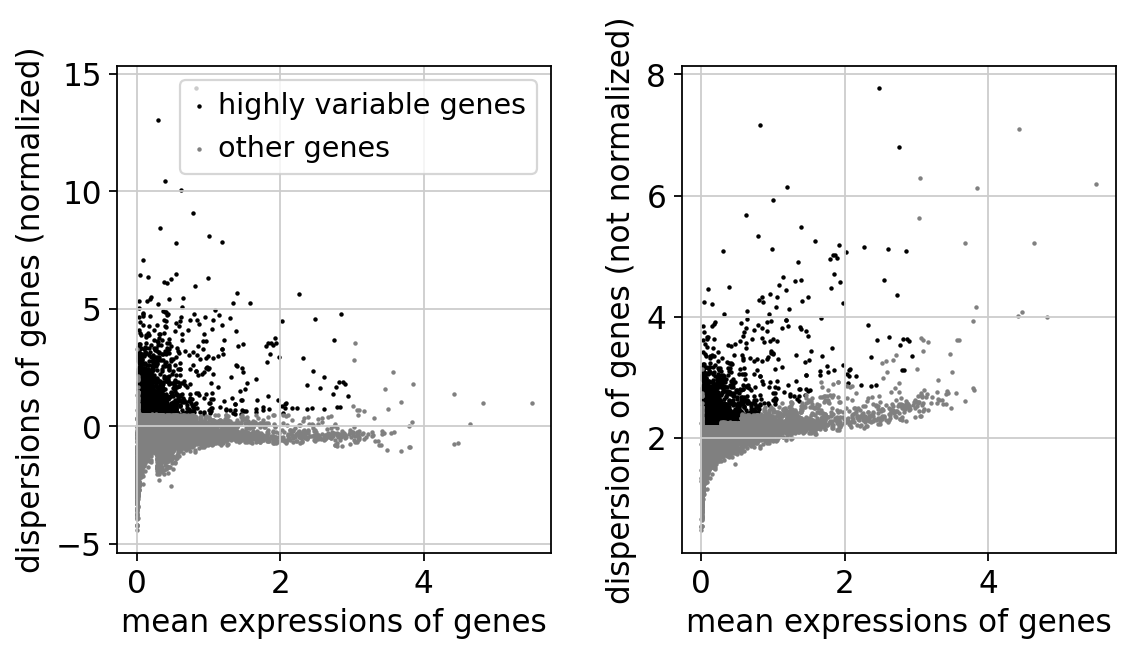

In [52]:
sc.pl.highly_variable_genes(sc_adata)

In [53]:
sc_adata = sc_adata[:, sc_adata.var.highly_variable]
sc.pp.regress_out(sc_adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(sc_adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:17)


and now QCing the bulk dataset:

normalizing counts per cell
    finished (0:00:00)


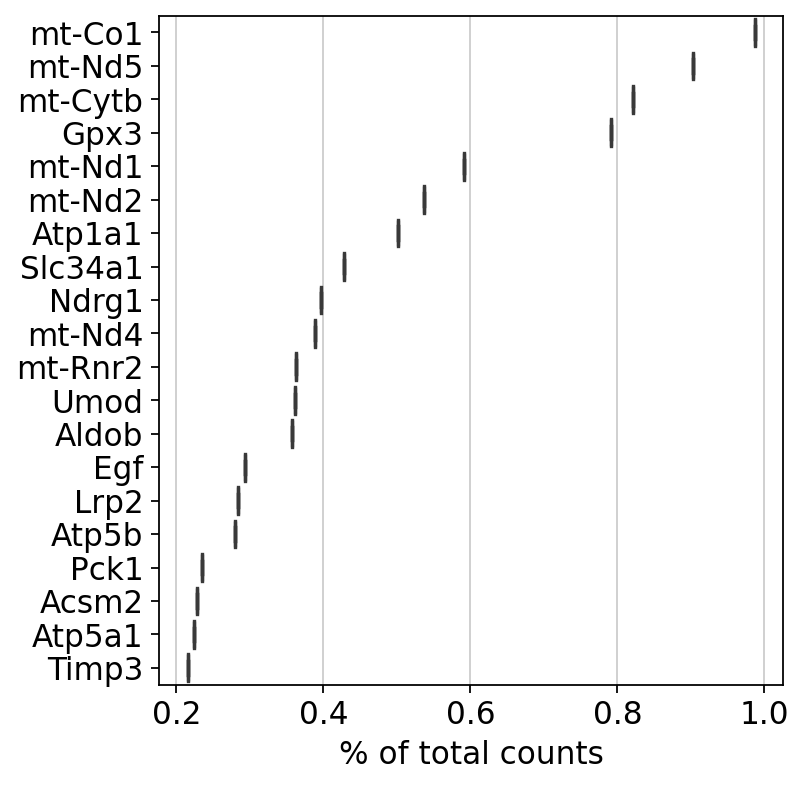

In [54]:
sc.pl.highest_expr_genes(bulk_adata, n_top=20, )

In [55]:
bulk_adata.var['mt'] = bulk_adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(bulk_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

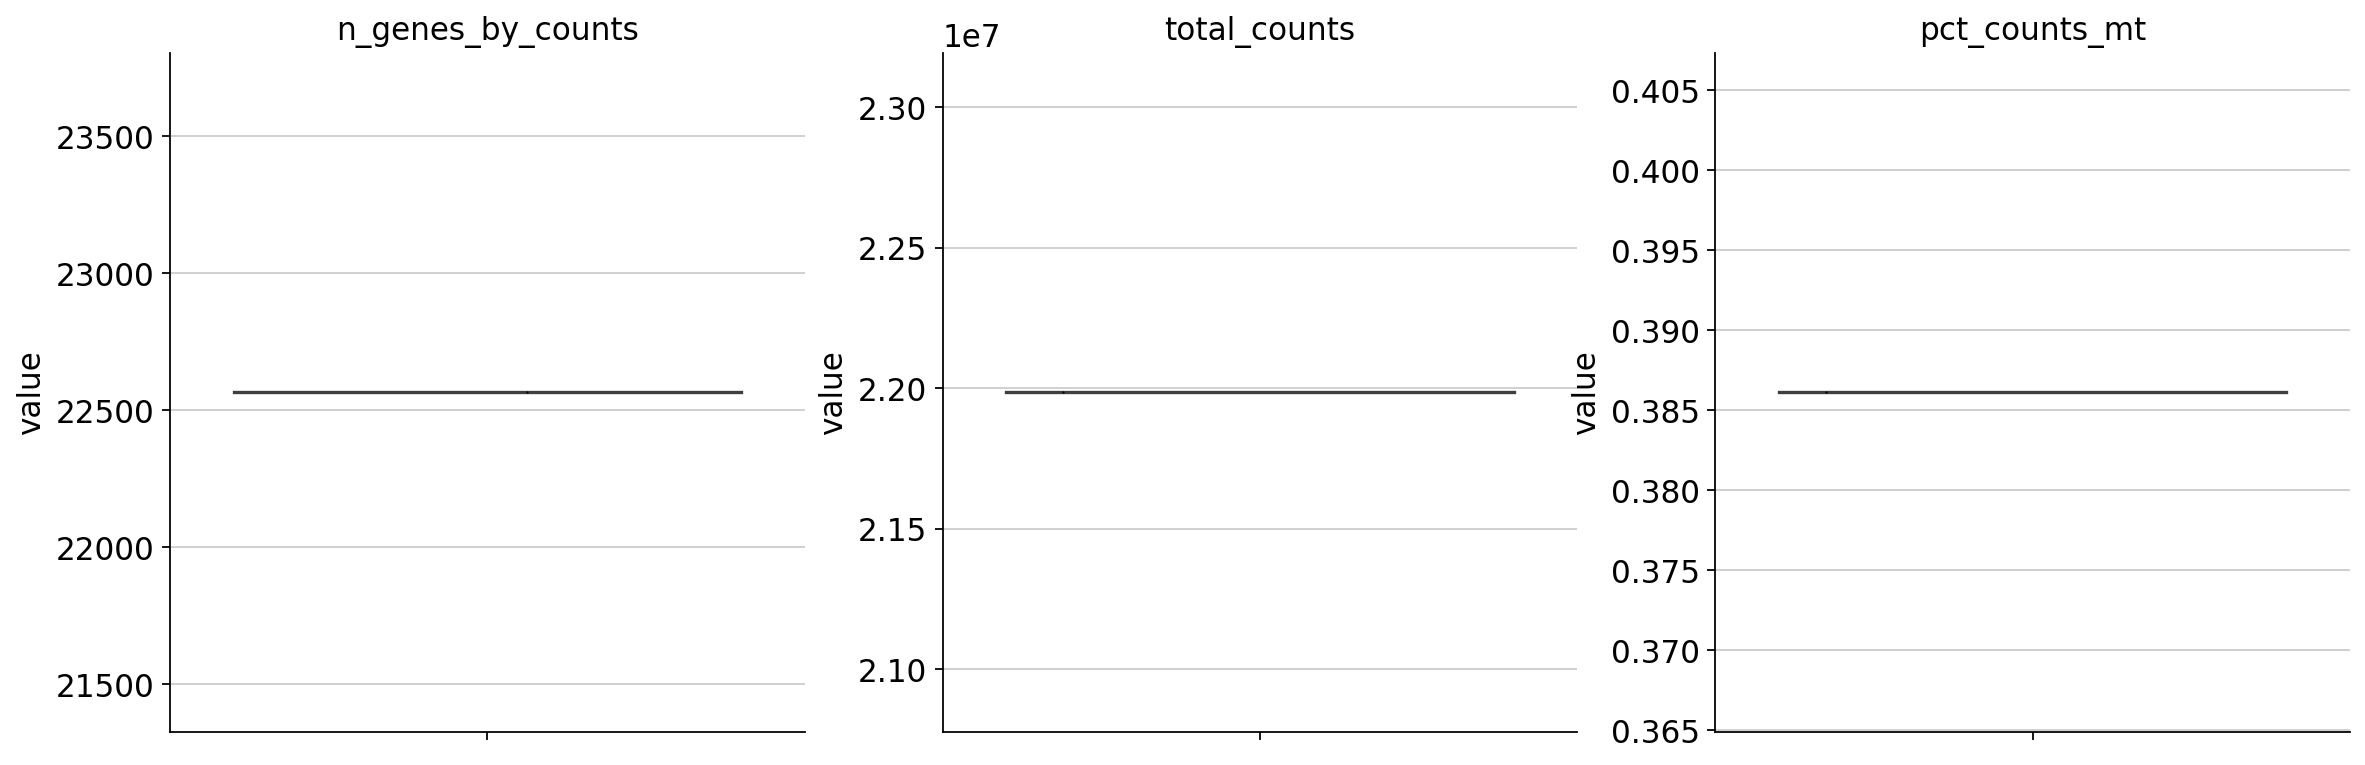

In [56]:
sc.pl.violin(bulk_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

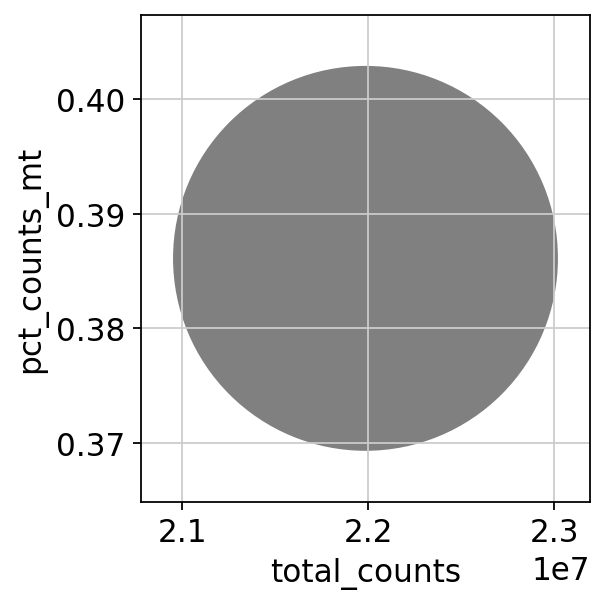

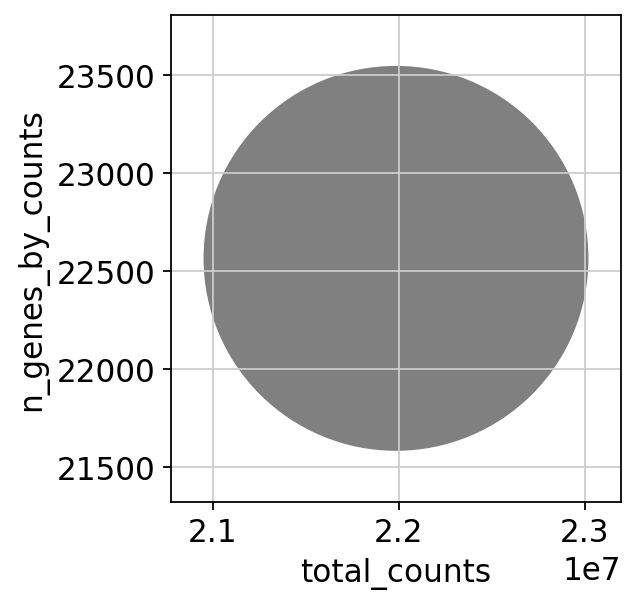

In [57]:
sc.pl.scatter(bulk_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(bulk_adata, x='total_counts', y='n_genes_by_counts')

In [58]:
#normalize and logarize:
sc.pp.normalize_total(bulk_adata, target_sum=1e4)
sc.pp.log1p(bulk_adata)
sc.pp.regress_out(bulk_adata, ['total_counts', 'pct_counts_mt'])

normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:00)


In [111]:
sn_genes = pd.DataFrame(sn_adata.var) 
sc_genes = pd.DataFrame(sc_adata.var)
bulk_genes = pd.DataFrame(bulk_adata.var)
sn_genes = sn_genes.transpose()
sc_genes = sc_genes.transpose()
bulk_genes = bulk_genes.transpose()

In [116]:
#common genes between SN and Bulk
common_genes_snwbulk = np.intersect1d(sn_genes.columns, bulk_genes.columns)
common_genes_snwbulk = list(common_genes_snwbulk)
#common genes between SC and Bulk
common_genes_scwbulk = np.intersect1d(sc_genes.columns, bulk_genes.columns)
common_genes_scwbulk = list(common_genes_scwbulk)

common_genes = np.intersect1d(sc_genes.columns, sn_genes.columns)
common_genes= list(common_genes)

common_genes_wbulk = np.intersect1d(common_genes, bulk_genes.columns)
common_genes_wbulk= list(common_genes_wbulk)

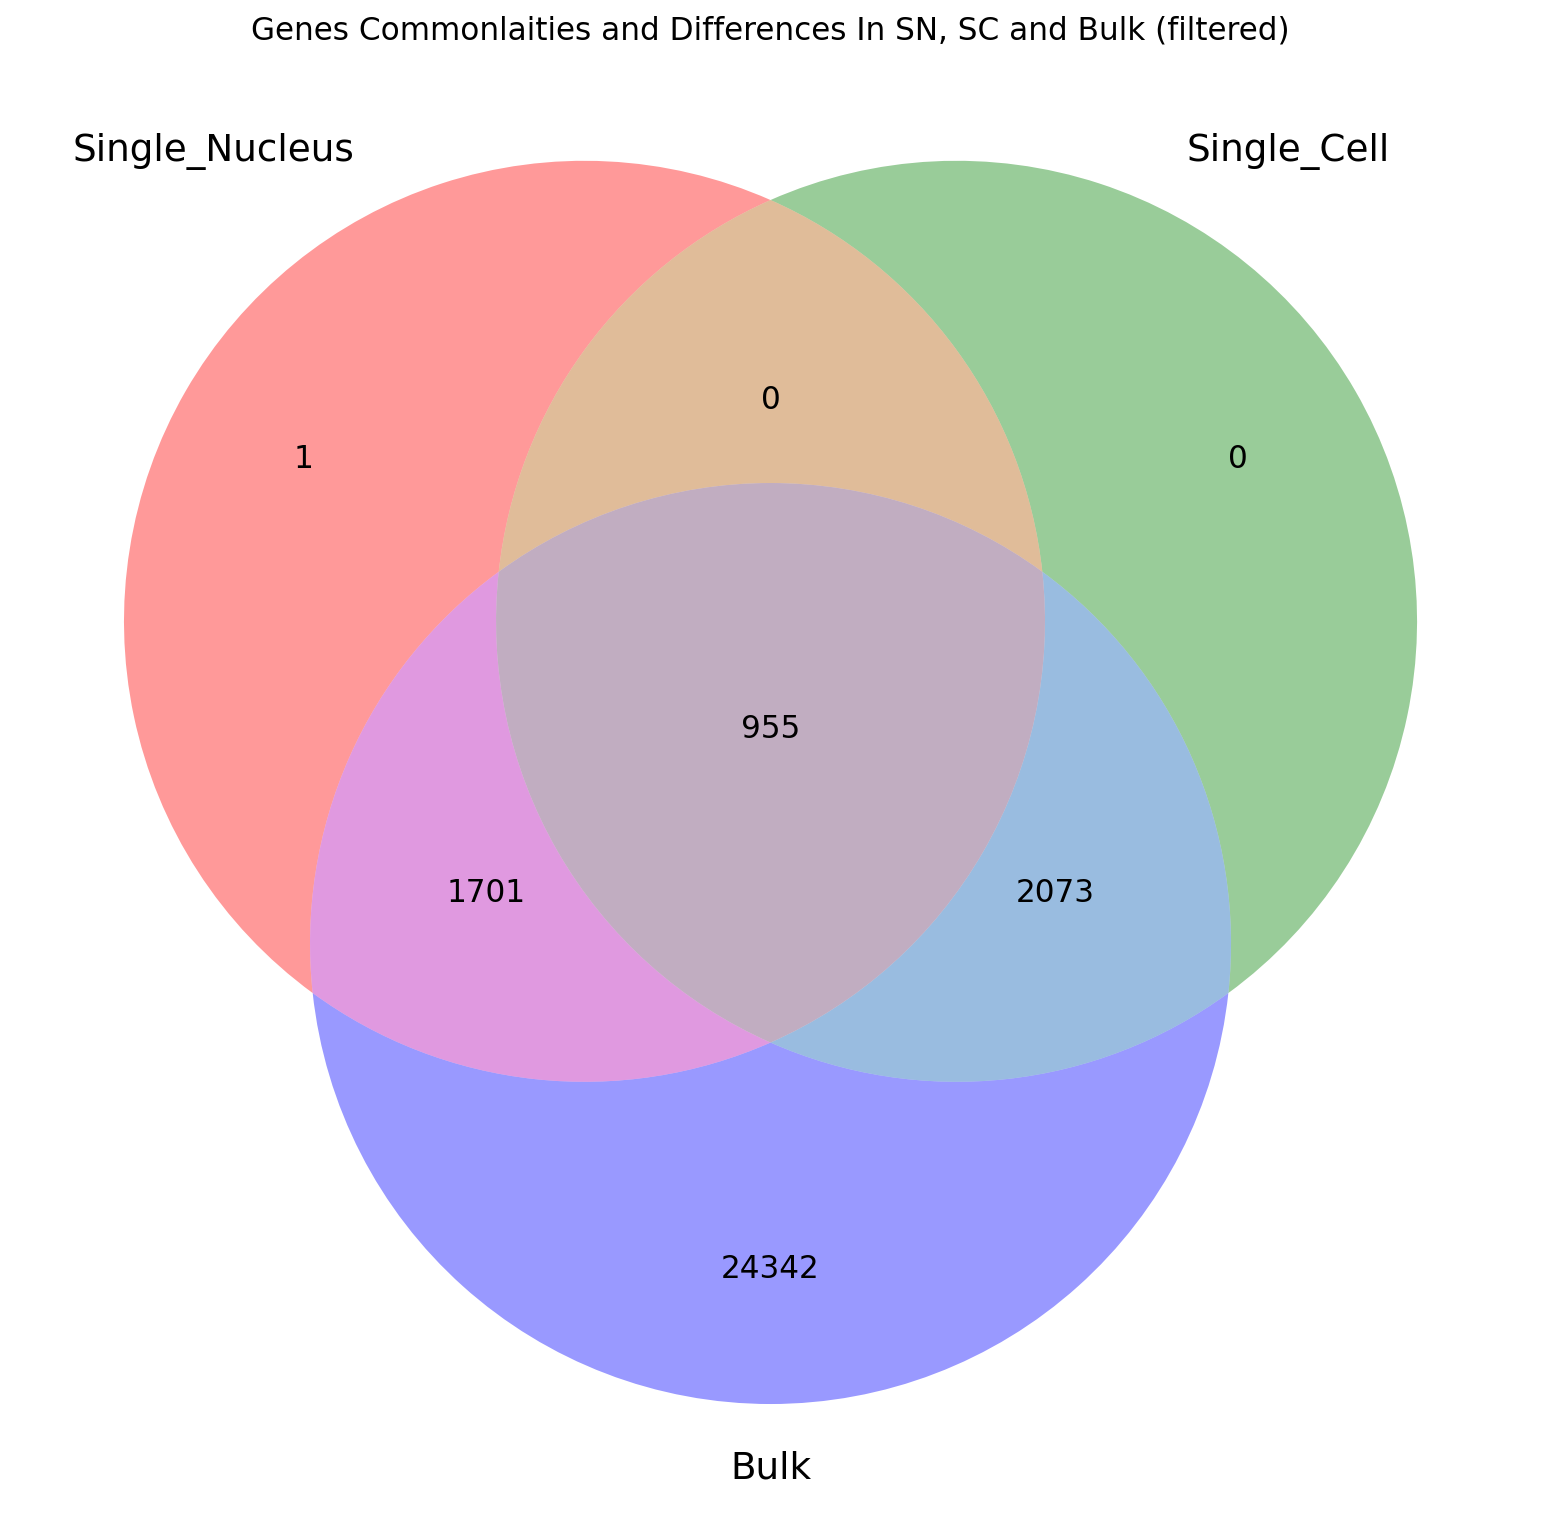

In [124]:
#common genes between bulk, SN, and SC.
len(common_genes_wbulk)

#common genes between SN and SC only, no bulk.
len(common_genes)

#calculating variables to plot on Venn and see gene discrepancies.
val5 =  len(np.setxor1d(common_genes_wbulk, common_genes_snwbulk))
val6 =  len(np.setxor1d(common_genes_wbulk, common_genes_scwbulk))
val3 = len(common_genes) - len(common_genes_wbulk)
val7 = len(common_genes_wbulk)
val4= bulk_genes.shape[1] - val7 - val5 - val6
val7 = len(common_genes_wbulk)
val1 = sn_genes.shape[1] - val3 - val7 - val5
val2 = sc_genes.shape[1] -  val3 - val7 - val6

#venn diagram for gene discrepancies
plt.figure(figsize=(15,12))  
gene_venn = venn3_unweighted(subsets =(val1, 
                            val2,
                            val3,
                            val4,
                            val5,
                            val6,
                            val7), 
                              set_labels = ('Single_Nucleus', 'Single_Cell', 'Bulk')
                            )
plt.title("Genes Commonlaities and Differences In SN, SC and Bulk (filtered)")                  
plt.show()

Computing Clustering:

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


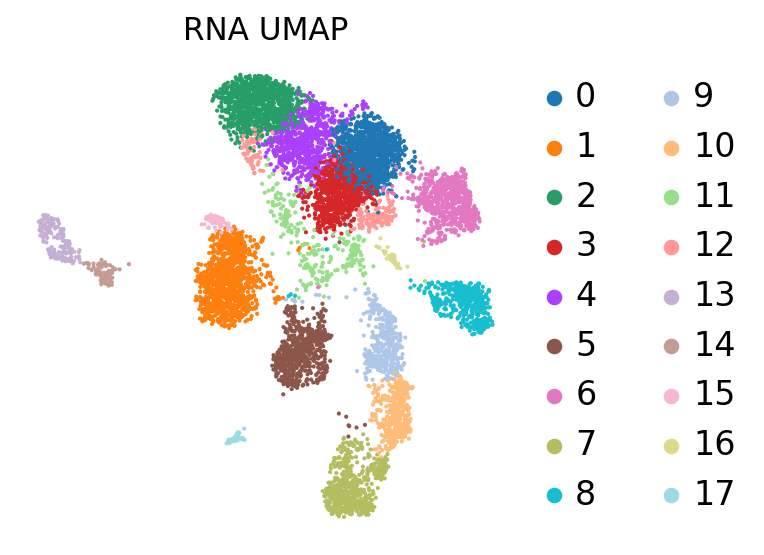

In [60]:
# Generate PCA features
sc.tl.pca(sn_adata , svd_solver='arpack')

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(sn_adata , n_neighbors=5, n_pcs=40)

# Generate UMAP features
sc.tl.umap(sn_adata )

# Run leiden clustering algorithm
sc.tl.leiden(sn_adata)
#sc.tl.louvain(sn_adata)

# Visualize
sc.pl.umap(sn_adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 31 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


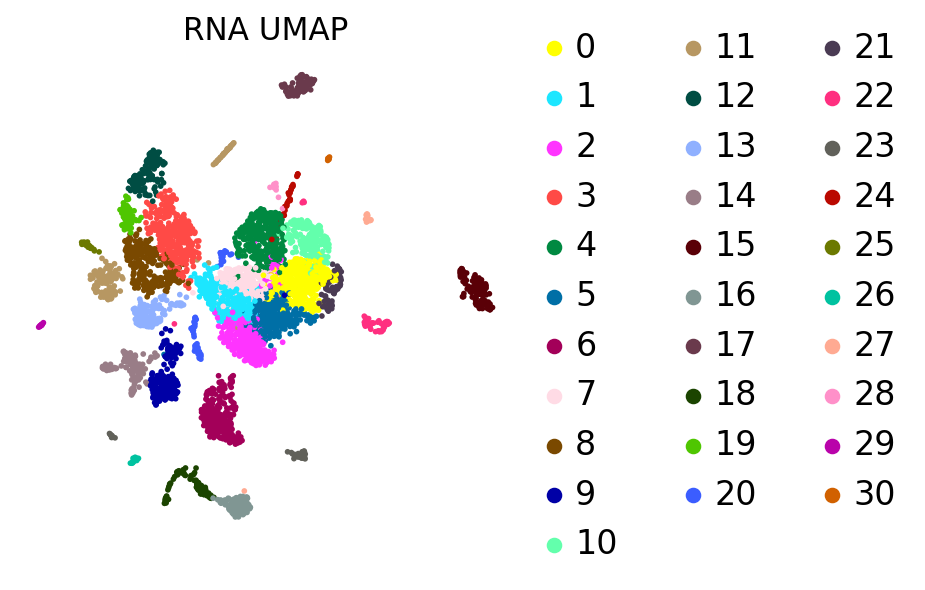

In [61]:
# Generate PCA features
sc.tl.pca(sc_adata, svd_solver='arpack')

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(sc_adata, n_neighbors=5, n_pcs=40)

# Generate UMAP features
sc.tl.umap(sc_adata)

# Run leiden and louvain clustering algorithm
sc.tl.leiden(sc_adata)
#sc.tl.louvain(sc_adata)

# Visualize
sc.pl.umap(sc_adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

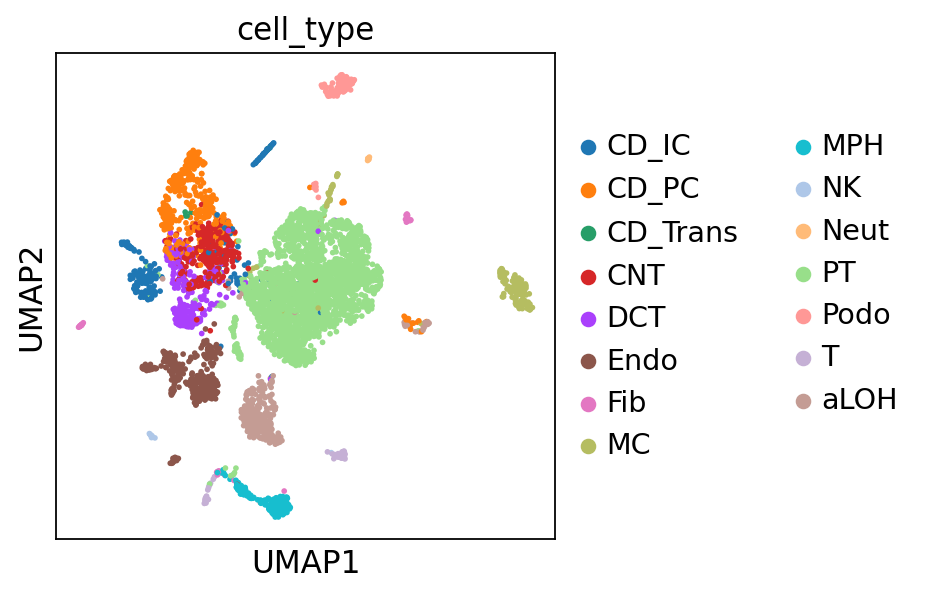

In [62]:
# Visualize cell assignments:
sc.pl.umap(sc_adata, color='cell_type')

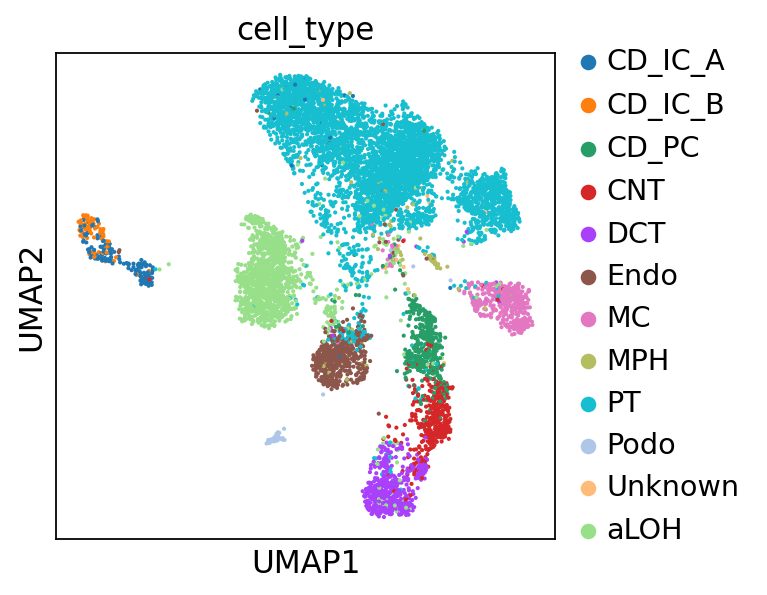

In [63]:
# Visualize cell assignments:
sc.pl.umap(sn_adata, color='cell_type')

B, B cells; 

CD-IC, collecting duct intercalated cells; 

CD-PC, collecting duct principal cells; 

CNT-CDT, connecting tubule and distal convoluted tubule cells; 

damaged PT, damaged proximal tubular cells; 

DC, dendritic cells; 

Endo, endothelial cells; 

LOH, loop of Henle cells; 

MΦ, macrophages; 

Mes, mesangial cells; 

NK, natural killer cells; 

Neutro, neutrophilic granulocytes; 

Podo, podocytes; 

PT, proximal tubular cells; 

T, T cells.


Matching cell types for comparison:

In [64]:
Counter(sn_adata.obs['cell_type'])

Counter({'aLOH': 1252,
         'PT': 4671,
         'CD_PC': 432,
         'DCT': 528,
         'MC': 403,
         'CNT': 396,
         'Podo': 46,
         'Endo': 524,
         'CD_IC_A': 179,
         'MPH': 83,
         'CD_IC_B': 84,
         'Unknown': 11})

In [65]:
new_cell_names_sn = dict(aLOH = 'aLOH',
                     PT = 'PT',
                     CD_PC = 'CD_PC',
                     DCT = 'DCT', 
                     MC = 'MC',
                     CNT = 'CNT', 
                     Podo = 'Podo', 
                     Endo = 'Endo', 
                     CD_IC_A = 'CD_IC', 
                     MPH = 'MPH',
                     CD_IC_B= 'CD_IC',
                     Unknown = 'Unknown')

sn_adata.obs['cell_type'] = (
    sn_adata.obs['cell_type']
    .map(new_cell_names_sn )
    .astype('category')
)


In [66]:
Counter(sn_adata.obs['cell_type'])

Counter({'aLOH': 1252,
         'PT': 4671,
         'CD_PC': 432,
         'DCT': 528,
         'MC': 403,
         'CNT': 396,
         'Podo': 46,
         'Endo': 524,
         'CD_IC': 263,
         'MPH': 83,
         'Unknown': 11})

In [67]:
Counter(sc_adata.obs['cell_type'])

Counter({'CD_IC': 211,
         'CNT': 298,
         'PT': 2308,
         'CD_PC': 374,
         'MC': 142,
         'Endo': 334,
         'DCT': 233,
         'Podo': 98,
         'aLOH': 303,
         'MPH': 156,
         'CD_Trans': 5,
         'NK': 11,
         'Fib': 33,
         'T': 46,
         'Neut': 7})

In [68]:
new_cell_names_sc = dict(
         CD_IC= 'CD_IC',
         CNT = 'CNT',
         PT= 'PT',
         CD_PC = 'CD_PC',
         MC = 'MC',
         Endo = 'Endo',
         DCT= 'DCT',
         Podo = 'Podo',
         aLOH = 'aLOH',
         MPH = 'MPH',
         CD_Trans= 'CD_Trans',
         NK = 'NK',
         Fib = 'Fib',
         T = 'T',
         Neut = 'Neut')

sc_adata.obs['cell_type'] = (
    sc_adata.obs['cell_type']
    .map(new_cell_names_sc )
    .astype('category')
)


In [69]:
sn_props = make_prop_table(sn_adata, 'cell_type')

╒════╤══════════════╤═════════════╤══════════════╕
│    │ Cell_Types   │   Num_Cells │   Prop_Cells │
╞════╪══════════════╪═════════════╪══════════════╡
│  0 │ aLOH         │        1252 │   0.145429   │
├────┼──────────────┼─────────────┼──────────────┤
│  1 │ PT           │        4671 │   0.542572   │
├────┼──────────────┼─────────────┼──────────────┤
│  2 │ CD_PC        │         432 │   0.05018    │
├────┼──────────────┼─────────────┼──────────────┤
│  3 │ DCT          │         528 │   0.0613312  │
├────┼──────────────┼─────────────┼──────────────┤
│  4 │ MC           │         403 │   0.0468115  │
├────┼──────────────┼─────────────┼──────────────┤
│  5 │ CNT          │         396 │   0.0459984  │
├────┼──────────────┼─────────────┼──────────────┤
│  6 │ Podo         │          46 │   0.00534325 │
├────┼──────────────┼─────────────┼──────────────┤
│  7 │ Endo         │         524 │   0.0608665  │
├────┼──────────────┼─────────────┼──────────────┤
│  8 │ CD_IC        │         2

In [70]:
sc_props = make_prop_table(sc_adata, 'cell_type')

╒════╤══════════════╤═════════════╤══════════════╕
│    │ Cell_Types   │   Num_Cells │   Prop_Cells │
╞════╪══════════════╪═════════════╪══════════════╡
│  0 │ CD_IC        │         211 │   0.0462821  │
├────┼──────────────┼─────────────┼──────────────┤
│  1 │ CNT          │         298 │   0.0653652  │
├────┼──────────────┼─────────────┼──────────────┤
│  2 │ PT           │        2308 │   0.506251   │
├────┼──────────────┼─────────────┼──────────────┤
│  3 │ CD_PC        │         374 │   0.0820355  │
├────┼──────────────┼─────────────┼──────────────┤
│  4 │ MC           │         142 │   0.0311472  │
├────┼──────────────┼─────────────┼──────────────┤
│  5 │ Endo         │         334 │   0.0732617  │
├────┼──────────────┼─────────────┼──────────────┤
│  6 │ DCT          │         233 │   0.0511077  │
├────┼──────────────┼─────────────┼──────────────┤
│  7 │ Podo         │          98 │   0.0214959  │
├────┼──────────────┼─────────────┼──────────────┤
│  8 │ aLOH         │         3

In [71]:
sn_props.sort_values('Cell_Types')

Cell_Types  Num_Cells  Prop_Cells
8       CD_IC        263    0.030549
2       CD_PC        432    0.050180
5         CNT        396    0.045998
3         DCT        528    0.061331
7        Endo        524    0.060867
4          MC        403    0.046811
9         MPH         83    0.009641
1          PT       4671    0.542572
6        Podo         46    0.005343
11      Total       8609    1.000000
10    Unknown         11    0.001278
0        aLOH       1252    0.145429

In [72]:
sc_props.sort_values('Cell_Types')

Cell_Types  Num_Cells  Prop_Cells
0       CD_IC        211    0.046282
3       CD_PC        374    0.082036
10   CD_Trans          5    0.001097
1         CNT        298    0.065365
6         DCT        233    0.051108
5        Endo        334    0.073262
12        Fib         33    0.007238
4          MC        142    0.031147
9         MPH        156    0.034218
11         NK         11    0.002413
14       Neut          7    0.001535
2          PT       2308    0.506251
7        Podo         98    0.021496
13          T         46    0.010090
15      Total       4559    1.000000
8        aLOH        303    0.066462

To compare, we're mergint the satasets together, but keeping origin as an obs.

In [73]:
sn_adata.obs['orig'] = 'single_nucleus'
together_sn = list()
counter_sn = 0
for value in sn_adata.obs['orig']:
    together_sn.append(f"{value}_{sn_adata.obs['cell_type'][counter_sn]}")
    counter_sn = counter_sn+1
together_sn   

['single_nucleus_aLOH',
 'single_nucleus_aLOH',
 'single_nucleus_aLOH',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_PT',
 'single_nucleus_CD_PC',
 'single_nucleus_PT',
 'single_nucleus_DCT',
 'single_nucleus_MC',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_CNT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_DCT',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_Podo',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_Endo',
 'single_nucleus_aLOH',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_aLOH',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_Endo',
 'single_nucleus_aLO

In [74]:
sn_adata.obs['orig_and_celltype'] = together_sn

In [75]:
sc_adata.obs['orig'] = 'single_cell'
together_sc = list()
counter_sc = 0
for value in sc_adata.obs['orig']:
    together_sc.append(f"{value}_{sc_adata.obs['cell_type'][counter_sc]}")
    counter_sc = counter_sc+1
together_sc   

['single_cell_CD_IC',
 'single_cell_CD_IC',
 'single_cell_CNT',
 'single_cell_PT',
 'single_cell_CD_PC',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_CD_IC',
 'single_cell_PT',
 'single_cell_MC',
 'single_cell_CNT',
 'single_cell_Endo',
 'single_cell_DCT',
 'single_cell_Podo',
 'single_cell_PT',
 'single_cell_aLOH',
 'single_cell_PT',
 'single_cell_DCT',
 'single_cell_DCT',
 'single_cell_MC',
 'single_cell_MPH',
 'single_cell_CD_IC',
 'single_cell_Podo',
 'single_cell_PT',
 'single_cell_CNT',
 'single_cell_PT',
 'single_cell_CNT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_CD_PC',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_CD_PC',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_DCT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_aLOH',
 'single_c

In [76]:
sc_adata.obs['orig_and_celltype'] = together_sc

In [77]:
#now combining both anndatas, outer and inner (including mismatch vs not including mismatch):
single_adata_inner = sn_adata.concatenate(sc_adata, join='inner')
single_adata_inner

AnnData object with n_obs × n_vars = 13168 × 955
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'orig', 'orig_and_celltype', 'batch'
    var: 'mt', 'highly_variable', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1'
    obsm: 'X_pca', 'X_umap'

In [78]:
#now combining both anndatas, outer and inner (including mismatch vs not including mismatch):
single_adata_outer = sn_adata.concatenate(sc_adata, join='outer')
single_adata_outer

AnnData object with n_obs × n_vars = 13168 × 4730
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'orig', 'orig_and_celltype', 'batch'
    var: 'n_cells-0', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1'
    obsm: 'X_pca', 'X_umap'

In [79]:
Counter(single_adata_inner.obs['cell_type'])

Counter({'aLOH': 1555,
         'PT': 6979,
         'CD_PC': 806,
         'DCT': 761,
         'MC': 545,
         'CNT': 694,
         'Podo': 144,
         'Endo': 858,
         'CD_IC': 474,
         'MPH': 239,
         'Unknown': 11,
         'CD_Trans': 5,
         'NK': 11,
         'Fib': 33,
         'T': 46,
         'Neut': 7})

Computing average gene expression per cell type and origin:

In [80]:
single_adata_inner.obs['orig_and_celltype'] =  single_adata_inner.obs['orig_and_celltype'].astype('category')

In [81]:
####Code altered from : https://scanpy.discourse.group/t/how-to-calculate-the-average-gene-expression-within-each-cluster/126/2
res_inner = pd.DataFrame(columns=single_adata_inner.var_names, index=single_adata_inner.obs['orig_and_celltype'].cat.categories) 
for clust in single_adata_inner.obs.orig_and_celltype.cat.categories: 
    res_inner.loc[clust] = single_adata_inner[single_adata_inner.obs['orig_and_celltype'].isin([clust]),:].X.mean(0)
#reordering columsn so they match    
res_inner = res_inner.reindex(sorted(res_inner.columns), axis=1)
res_inner  #res inner now contains the mean expression per gene of each cell type

1700025G04Rik 1700040L02Rik 1700066B19Rik  \
single_cell_CD_IC           0.086509      0.281462     -0.058871   
single_cell_CD_PC          -0.103755      0.183945       0.07642   
single_cell_CD_Trans       -0.150161     -0.366586     -0.071097   
single_cell_CNT            -0.157095      0.315371     -0.028076   
single_cell_DCT            -0.106779      0.535196     -0.035679   
single_cell_Endo            0.921152     -0.126932     -0.044056   
single_cell_Fib             0.301335     -0.266794     -0.037138   
single_cell_MC              0.359697     -0.104853     -0.037091   
single_cell_MPH             0.176239     -0.181448      0.031051   
single_cell_NK              0.941271     -0.209456     -0.039553   
single_cell_Neut             -0.2017      -0.12519     -0.026737   
single_cell_PT             -0.167239     -0.127292     -0.032435   
single_cell_Podo             0.81887     -0.311523     -0.052676   
single_cell_T               0.427634     -0.199139      -0.03372   
single_cell_aLOH           -0.093238        0.2839      0.044887   
single_nucleus_CD_IC        0.185269      0.106189     -0.000584   
single_nucleus_CD_PC       -0.055362      0.077858      0.004168   
single_nucleus_CNT         -0.104748      0.215876      0.140091   
single_nucleus_DCT         -0.007945      0.291556      0.145249   
single_nucleus_Endo         0.662938     -0.271596     -0.035319   
single_nucleus_MC           0.127707     -0.234522     -0.063224   
single_nucleus_MPH          0.359413     -0.258448     -0.110409   
single_nucleus_PT          -0.065964     -0.086699     -0.034629   
single_nucleus_Podo           0.0761      -0.17296     -0.112183   
single_nucleus_Unknown     -0.157707      0.063068     -0.117358   
single_nucleus_aLOH        -0.088472      0.295147      0.013103   

                       1810011O10Rik 2010007H06Rik 2700033N17Rik  \
single_cell_CD_IC          -0.270011      0.158357     -0.087064   
single_cell_CD_PC          -0.208539     -0.023302     -0.114391   
single_cell_CD_Trans        0.251537     -0.101565     -0.105852   
single_cell_CNT            -0.228076     -0.059362     -0.084602   
single_cell_DCT            -0.158095      0.125545     -0.102878   
single_cell_Endo            2.117623      0.061194      0.916606   
single_cell_Fib            -0.179346      -0.11571     -0.168172   
single_cell_MC              0.059628     -0.019971      0.008899   
single_cell_MPH            -0.244451     -0.007007     -0.114612   
single_cell_NK             -0.268104      -0.07505     -0.147864   
single_cell_Neut           -0.284365     -0.051707       -0.1599   
single_cell_PT             -0.230019     -0.051547     -0.064459   
single_cell_Podo           -0.223057     -0.043562     -0.086539   
single_cell_T              -0.258206      0.137244     -0.160249   
single_cell_aLOH            0.450071       0.05255     -0.071647   
single_nucleus_CD_IC       -0.131592      0.130422     -0.066447   
single_nucleus_CD_PC       -0.107314      0.009765     -0.074441   
single_nucleus_CNT         -0.114716      0.127085      0.004772   
single_nucleus_DCT         -0.093114     -0.009913     -0.068292   
single_nucleus_Endo         0.888282     -0.083387      0.214038   
single_nucleus_MC          -0.075185     -0.026386     -0.022851   
single_nucleus_MPH         -0.049621      0.019654      0.048244   
single_nucleus_PT          -0.056196       -0.0262     -0.030947   
single_nucleus_Podo         0.103974      0.103292      0.144324   
single_nucleus_Unknown       -0.1825     -0.105443      -0.07711   
single_nucleus_aLOH         0.003383      0.006534       -0.0597   

                       2700081O15Rik 3110099E03Rik 4632411P08Rik  \
single_cell_CD_IC           0.025394     -0.111445      0.079533   
single_cell_CD_PC           0.054299     -0.094776      0.046158   
single_cell_CD_Trans       -0.138283     -0.096509     -0.077486   
single_cell_CNT            -0.125547     -0.116141     -0.031991   
single_ce

Comparing average gene expression per cell type in sn vs. sc:

In [82]:
#First extracting cells that are matching and non-matching
matching_celltypes = list(['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH'])
nonmatching_celltypes = list(['CD_Trans', 'NK', 'Fib', 'Unknown'])
len(matching_celltypes)

10

In [253]:
#Creating dataframes to append average data
av_df = pd.DataFrame(columns=["SN", "SC"], index=res_inner.columns)
av_df_celltype = pd.DataFrame(columns=single_adata_inner.obs['orig_and_celltype'], index=res_inner.columns)

mse_df = pd.DataFrame(columns=res_inner.columns, index = matching_celltypes)
mse_df_snbulk  = pd.DataFrame(columns=res_inner.columns)
mse_df_scbulk  = pd.DataFrame(columns=res_inner.columns)

pearson_df_snsc = pd.DataFrame(columns = matching_celltypes, index = ["PearsonCorr"])
pear_df_snbulk = pd.DataFrame(columns = matching_celltypes, index = ["PearsonCorr"])
pear_df_scbulk = pd.DataFrame(columns = matching_celltypes, index = ["PearsonCorr"])

In [254]:
res_inner

1700025G04Rik 1700040L02Rik 1700066B19Rik  \
single_cell_CD_IC           0.086509      0.281462     -0.058871   
single_cell_CD_PC          -0.103755      0.183945       0.07642   
single_cell_CD_Trans       -0.150161     -0.366586     -0.071097   
single_cell_CNT            -0.157095      0.315371     -0.028076   
single_cell_DCT            -0.106779      0.535196     -0.035679   
single_cell_Endo            0.921152     -0.126932     -0.044056   
single_cell_Fib             0.301335     -0.266794     -0.037138   
single_cell_MC              0.359697     -0.104853     -0.037091   
single_cell_MPH             0.176239     -0.181448      0.031051   
single_cell_NK              0.941271     -0.209456     -0.039553   
single_cell_Neut             -0.2017      -0.12519     -0.026737   
single_cell_PT             -0.167239     -0.127292     -0.032435   
single_cell_Podo             0.81887     -0.311523     -0.052676   
single_cell_T               0.427634     -0.199139      -0.03372   
single_cell_aLOH           -0.093238        0.2839      0.044887   
single_nucleus_CD_IC        0.185269      0.106189     -0.000584   
single_nucleus_CD_PC       -0.055362      0.077858      0.004168   
single_nucleus_CNT         -0.104748      0.215876      0.140091   
single_nucleus_DCT         -0.007945      0.291556      0.145249   
single_nucleus_Endo         0.662938     -0.271596     -0.035319   
single_nucleus_MC           0.127707     -0.234522     -0.063224   
single_nucleus_MPH          0.359413     -0.258448     -0.110409   
single_nucleus_PT          -0.065964     -0.086699     -0.034629   
single_nucleus_Podo           0.0761      -0.17296     -0.112183   
single_nucleus_Unknown     -0.157707      0.063068     -0.117358   
single_nucleus_aLOH        -0.088472      0.295147      0.013103   

                       1810011O10Rik 2010007H06Rik 2700033N17Rik  \
single_cell_CD_IC          -0.270011      0.158357     -0.087064   
single_cell_CD_PC          -0.208539     -0.023302     -0.114391   
single_cell_CD_Trans        0.251537     -0.101565     -0.105852   
single_cell_CNT            -0.228076     -0.059362     -0.084602   
single_cell_DCT            -0.158095      0.125545     -0.102878   
single_cell_Endo            2.117623      0.061194      0.916606   
single_cell_Fib            -0.179346      -0.11571     -0.168172   
single_cell_MC              0.059628     -0.019971      0.008899   
single_cell_MPH            -0.244451     -0.007007     -0.114612   
single_cell_NK             -0.268104      -0.07505     -0.147864   
single_cell_Neut           -0.284365     -0.051707       -0.1599   
single_cell_PT             -0.230019     -0.051547     -0.064459   
single_cell_Podo           -0.223057     -0.043562     -0.086539   
single_cell_T              -0.258206      0.137244     -0.160249   
single_cell_aLOH            0.450071       0.05255     -0.071647   
single_nucleus_CD_IC       -0.131592      0.130422     -0.066447   
single_nucleus_CD_PC       -0.107314      0.009765     -0.074441   
single_nucleus_CNT         -0.114716      0.127085      0.004772   
single_nucleus_DCT         -0.093114     -0.009913     -0.068292   
single_nucleus_Endo         0.888282     -0.083387      0.214038   
single_nucleus_MC          -0.075185     -0.026386     -0.022851   
single_nucleus_MPH         -0.049621      0.019654      0.048244   
single_nucleus_PT          -0.056196       -0.0262     -0.030947   
single_nucleus_Podo         0.103974      0.103292      0.144324   
single_nucleus_Unknown       -0.1825     -0.105443      -0.07711   
single_nucleus_aLOH         0.003383      0.006534       -0.0597   

                       2700081O15Rik 3110099E03Rik 4632411P08Rik  \
single_cell_CD_IC           0.025394     -0.111445      0.079533   
single_cell_CD_PC           0.054299     -0.094776      0.046158   
single_cell_CD_Trans       -0.138283     -0.096509     -0.077486   
single_cell_CNT            -0.125547     -0.116141     -0.031991   
single_ce

In [255]:
for gene in res_inner.columns:
    for cell in matching_celltypes:
        #mean of all the expression of celltype in gene in sc and sn
        av_df["SC"][gene] = res_inner.loc[f"single_cell_{cell}"][gene]
        av_df["SN"][gene] = res_inner.loc[f"single_nucleus_{cell}"][gene]
av_df

SN        SC
1700025G04Rik -0.088472 -0.093238
1700040L02Rik  0.295147    0.2839
1700066B19Rik  0.013103  0.044887
1810011O10Rik  0.003383  0.450071
2010007H06Rik  0.006534   0.05255
...                 ...       ...
Zfp385b        0.055387 -0.018843
Zfp521           0.2173  0.093843
Zfp658         -0.02939  0.033178
Zfp711         0.086343  0.155572
Zfr2           0.108156 -0.040654

[955 rows x 2 columns]

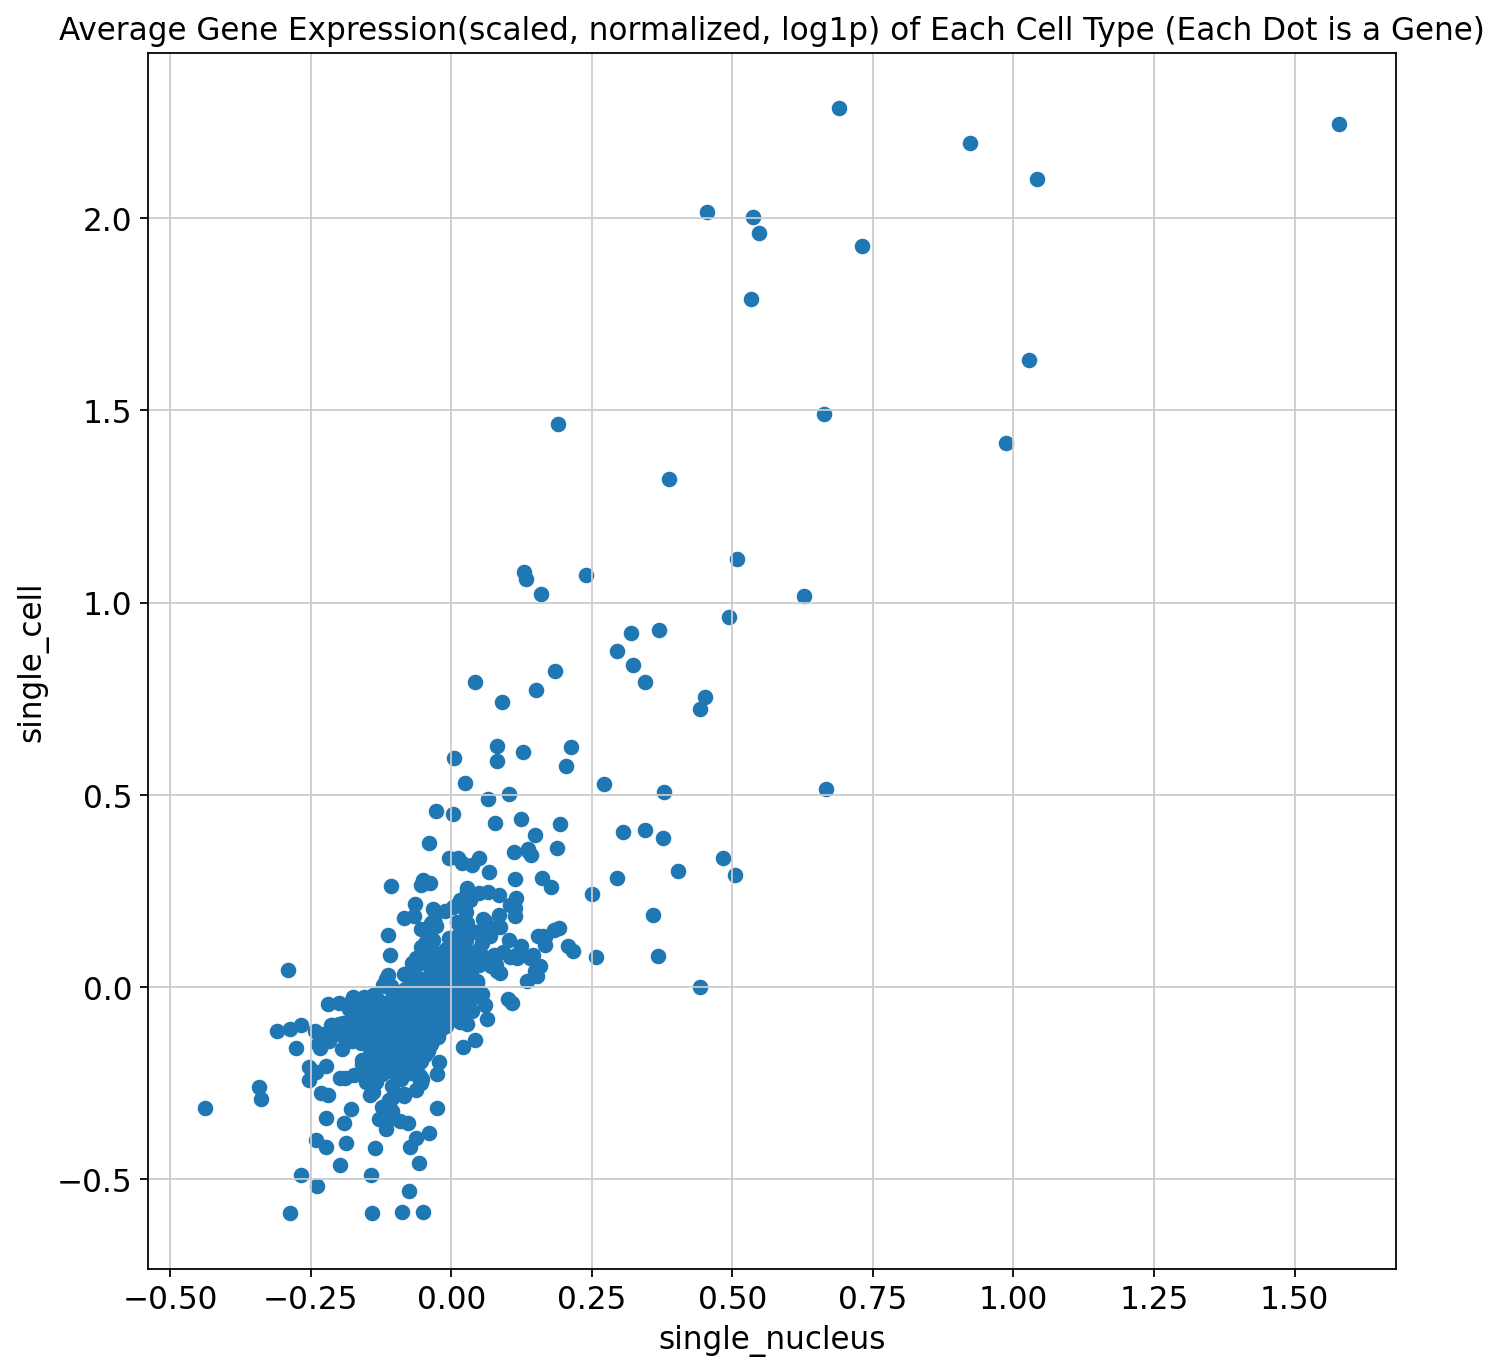

In [256]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df["SN"], y = av_df["SC"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, log1p) of Each Cell Type (Each Dot is a Gene)")
plt.show()

In [313]:
av_df_celltype["single_cell_CD_IC"]

1700025G04Rik    0.086509
1700040L02Rik    0.281462
1700066B19Rik   -0.058871
1810011O10Rik   -0.270011
2010007H06Rik    0.158357
                   ...   
Zfp385b          0.100158
Zfp521           0.036316
Zfp658          -0.066856
Zfp711           0.034165
Zfr2             0.147814
Name: single_cell_CD_IC, Length: 955, dtype: object

In [316]:
matching_celltypes

['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH']

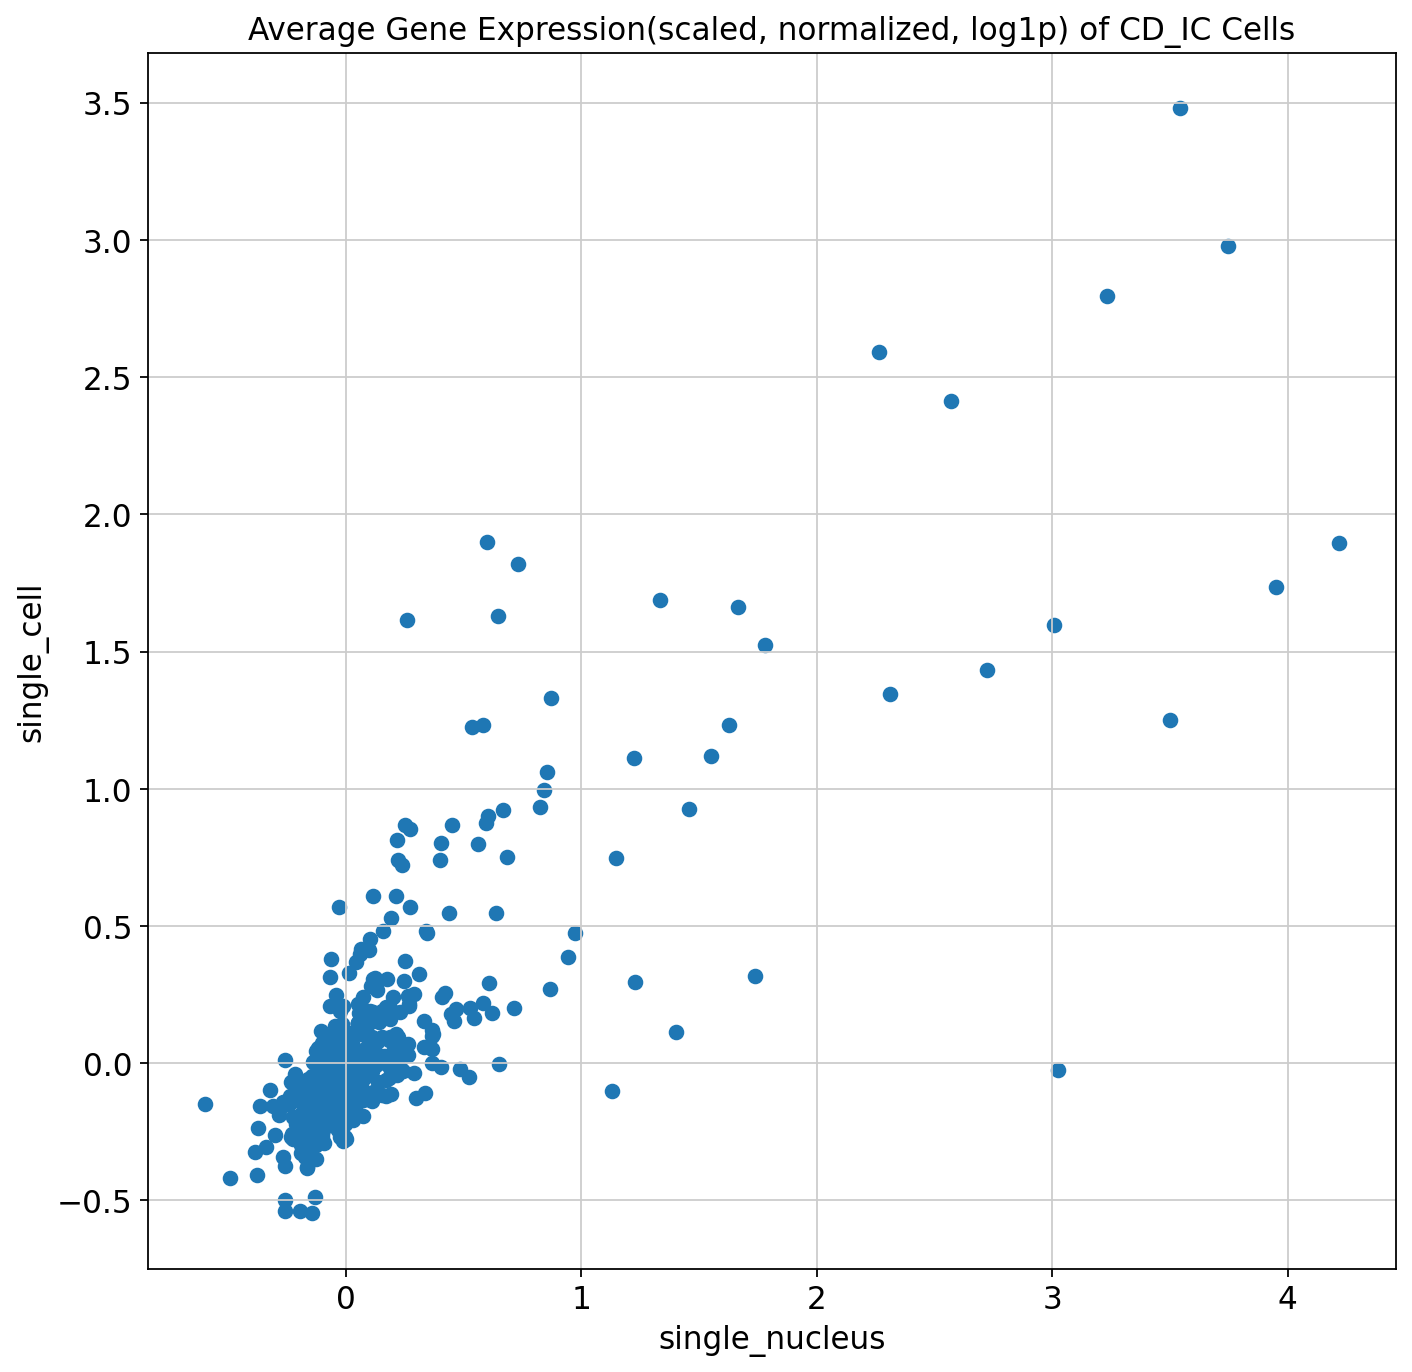

In [315]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_CD_IC"], y = av_df_celltype["single_cell_CD_IC"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, log1p) of CD_IC Cells")
plt.show()

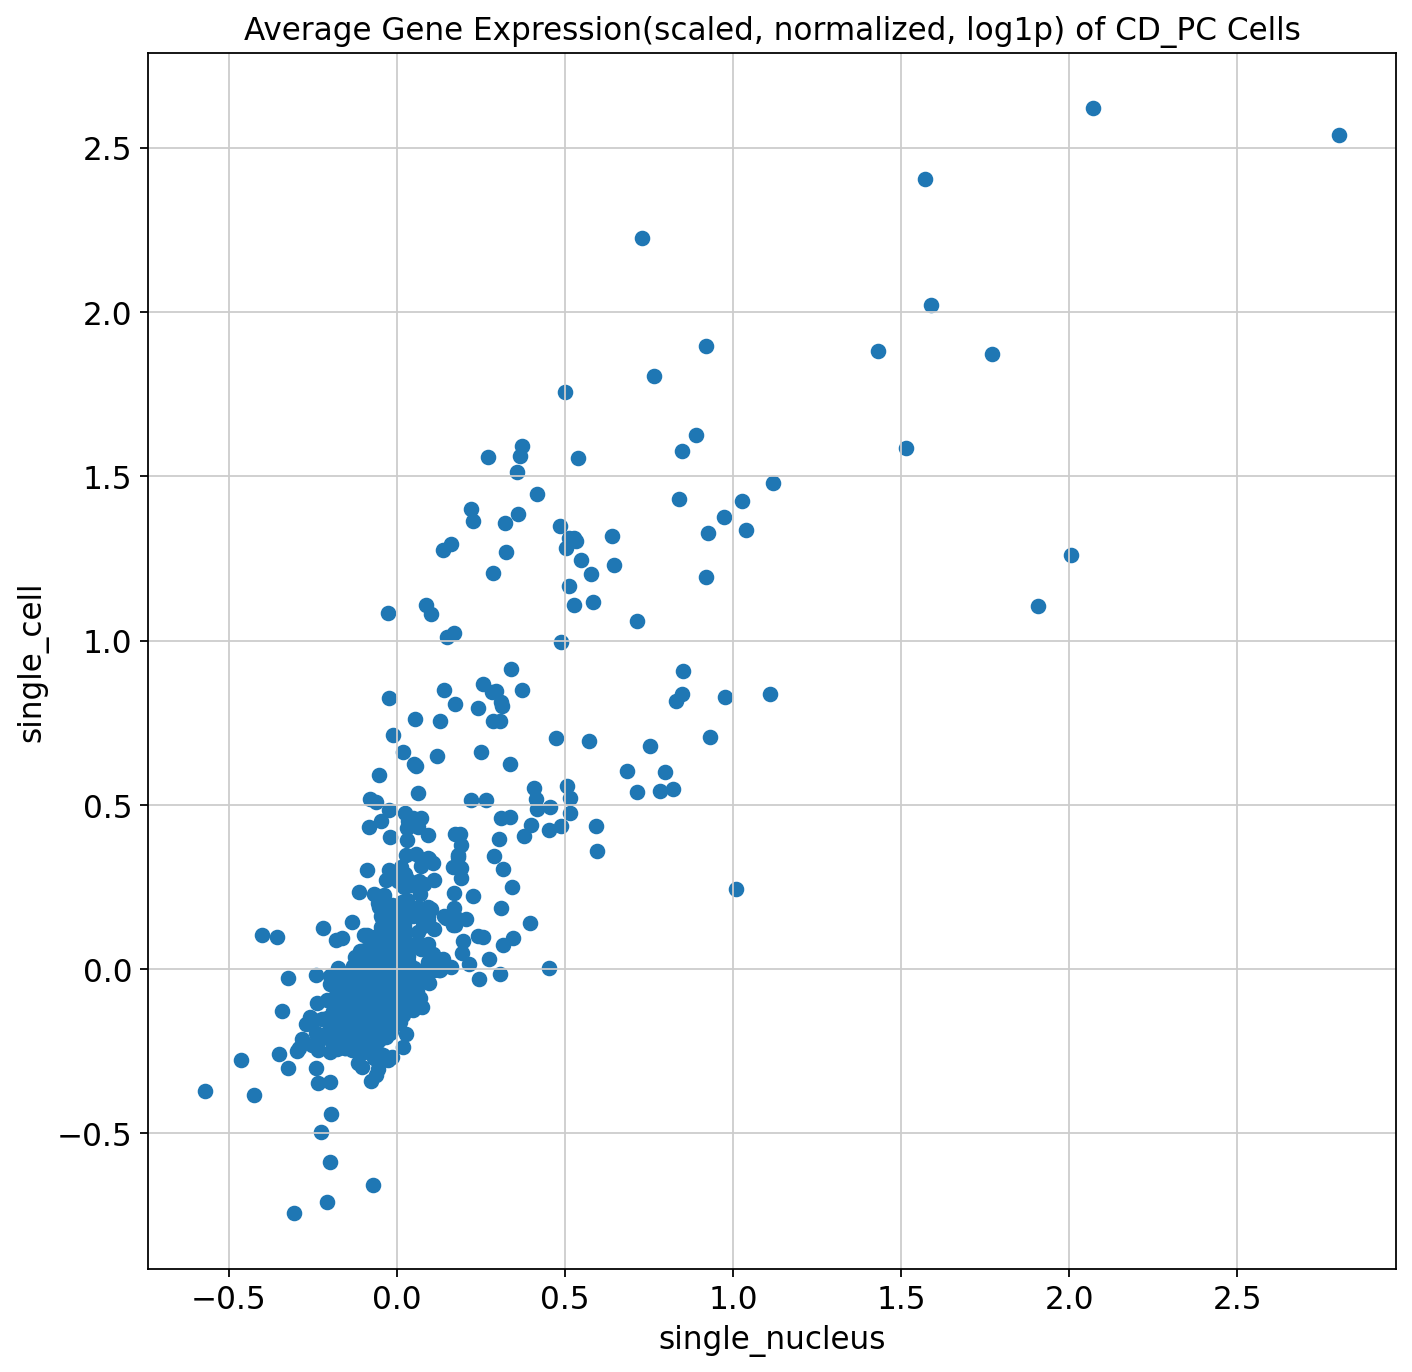

In [317]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_CD_PC"], y = av_df_celltype["single_cell_CD_PC"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, log1p) of CD_PC Cells")
plt.show()

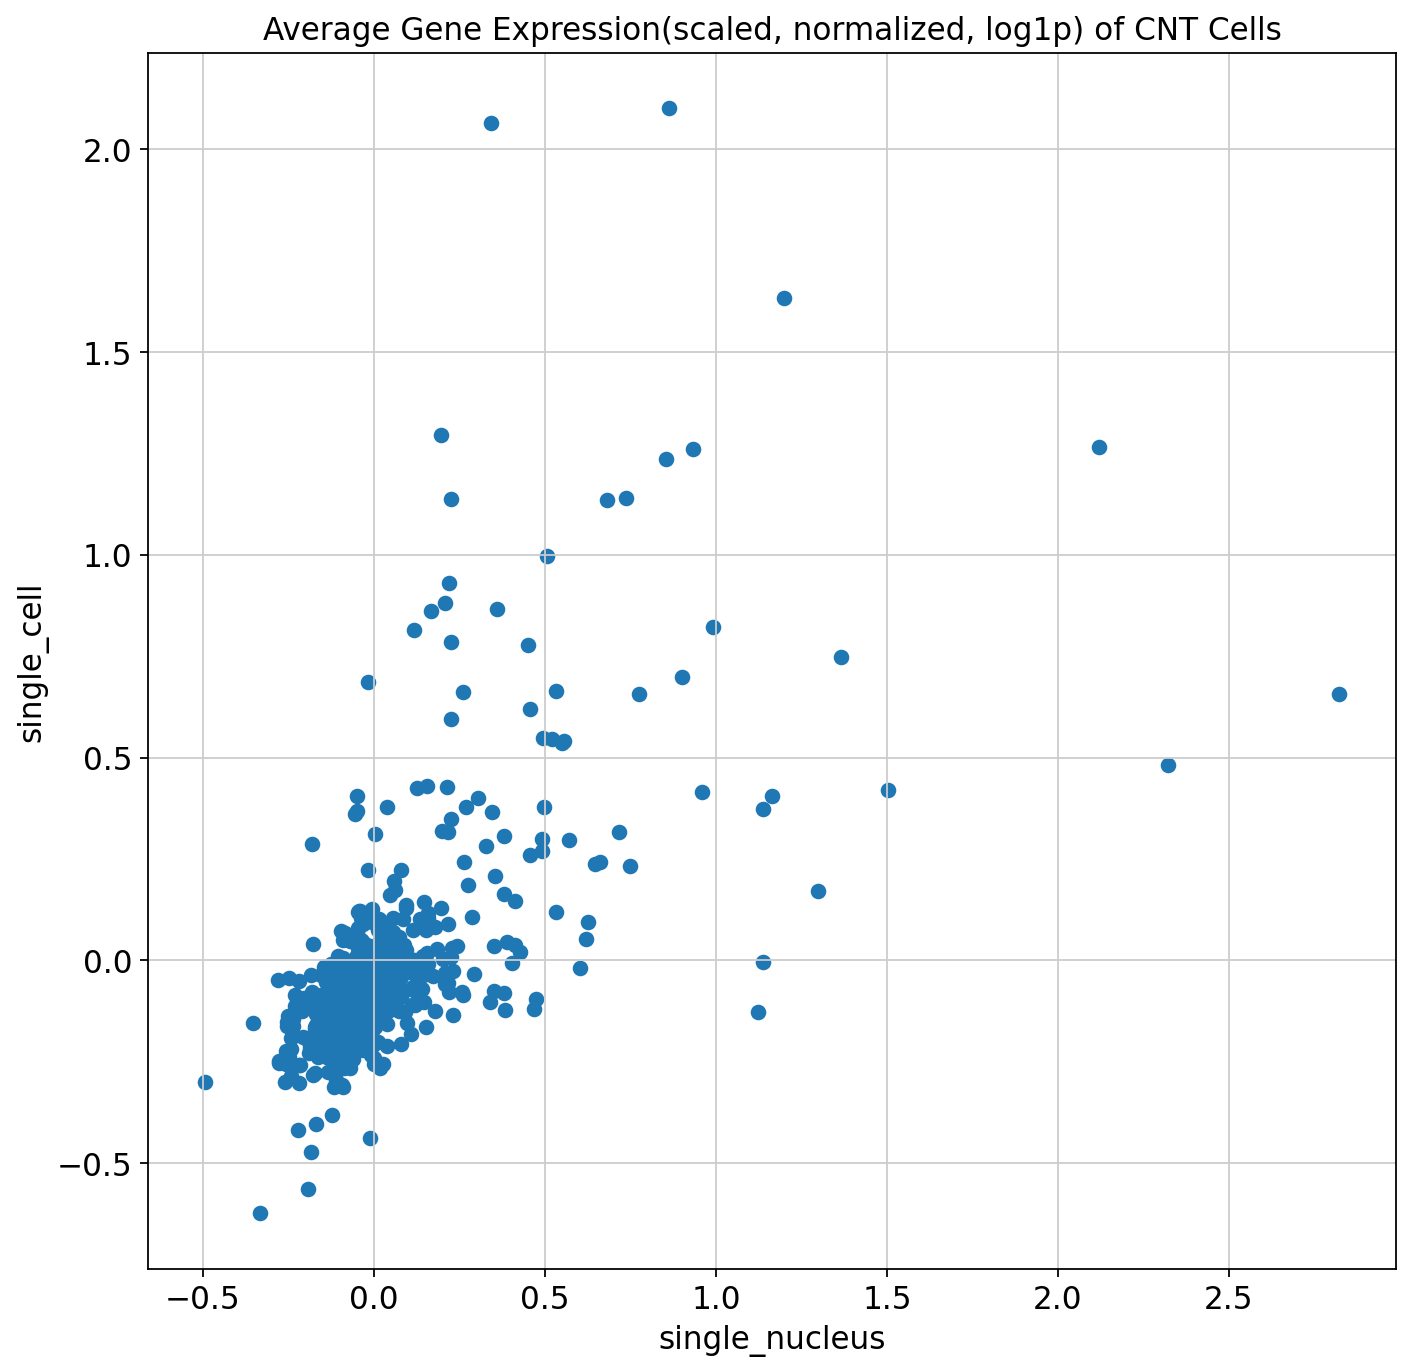

In [318]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_CNT"], y = av_df_celltype["single_cell_CNT"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, log1p) of CNT Cells")
plt.show()

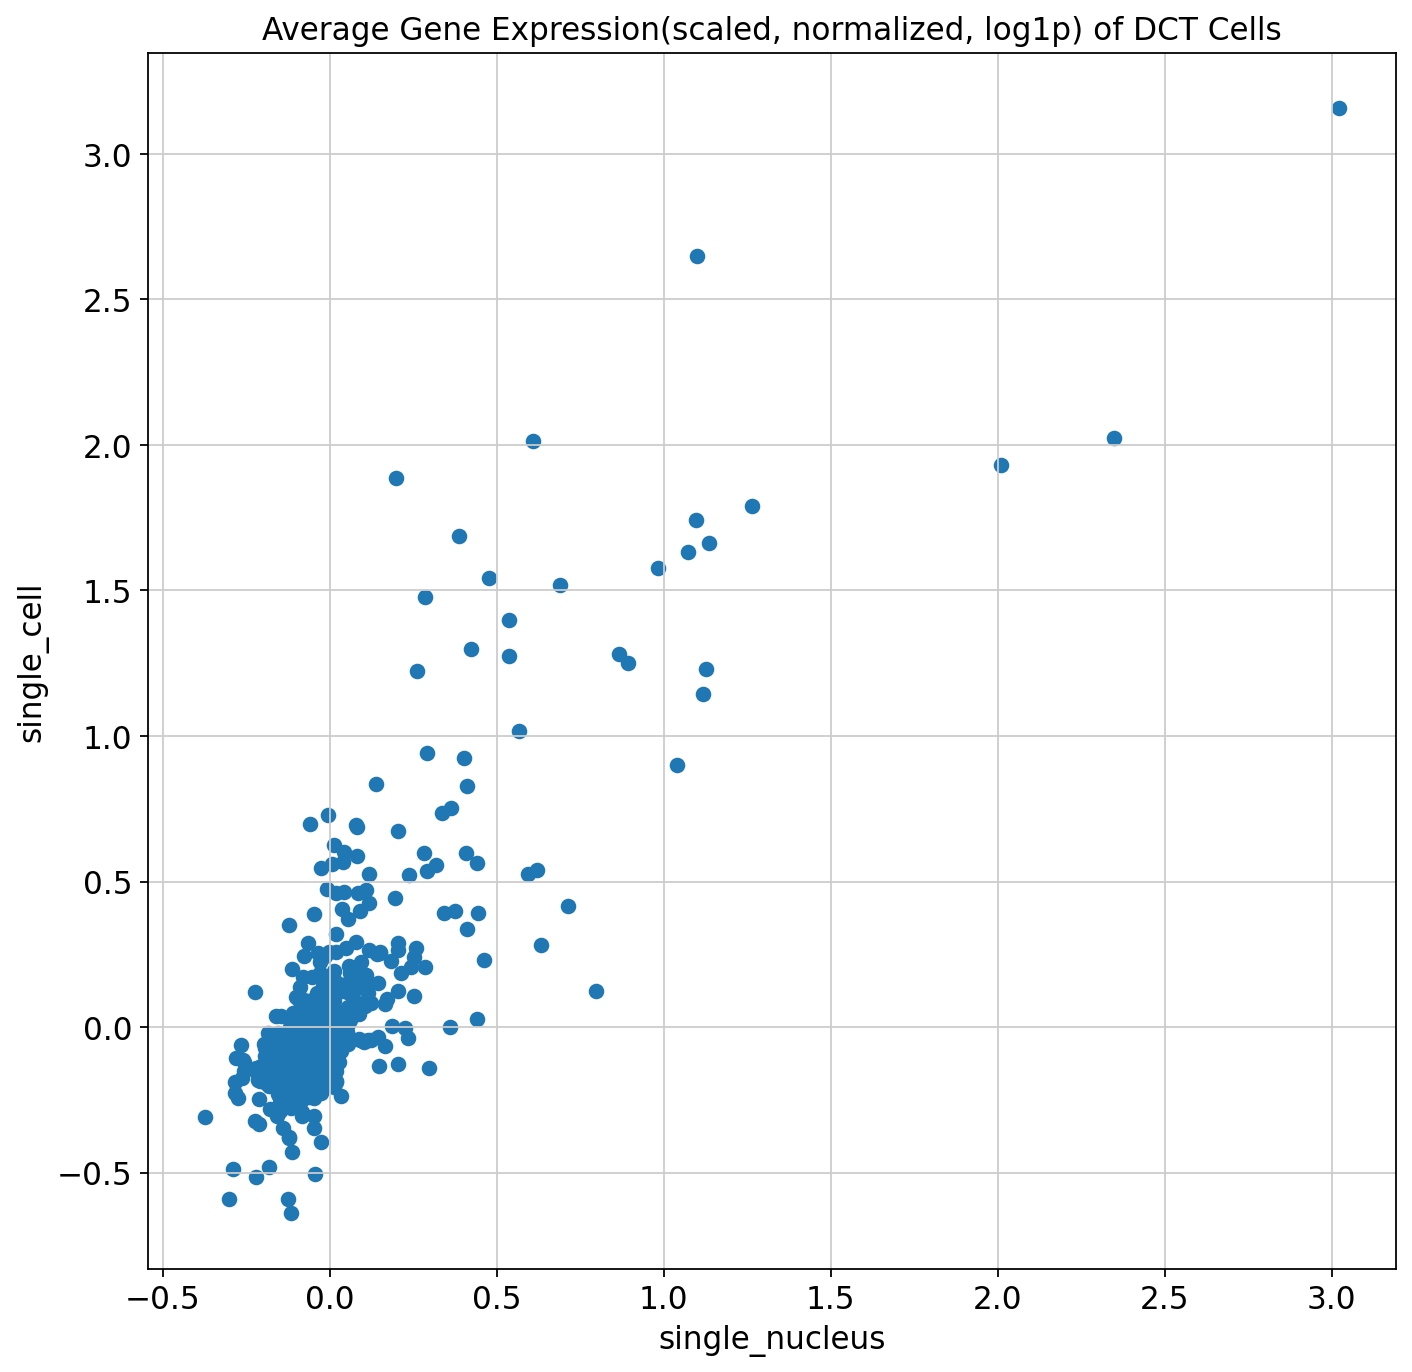

In [319]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_DCT"], y = av_df_celltype["single_cell_DCT"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, log1p) of DCT Cells")
plt.show()

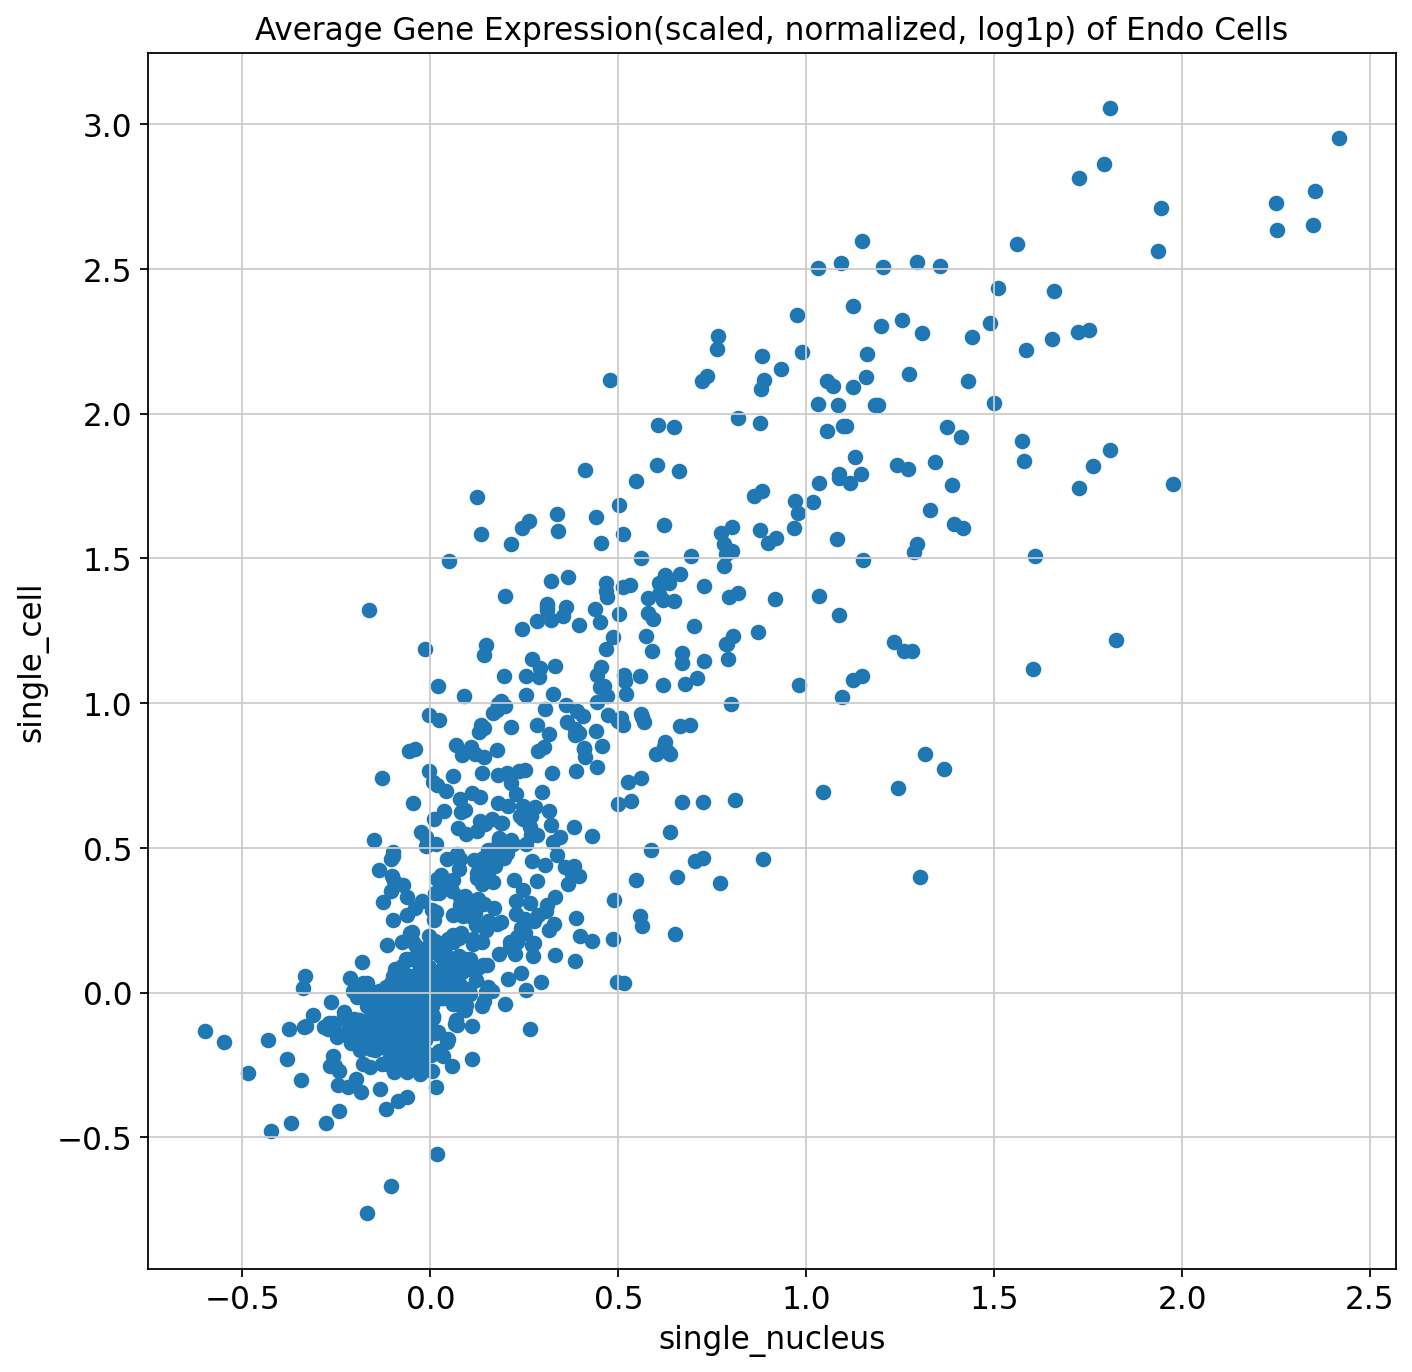

In [321]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_Endo"], y = av_df_celltype["single_cell_Endo"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, log1p) of Endo Cells")
plt.show()

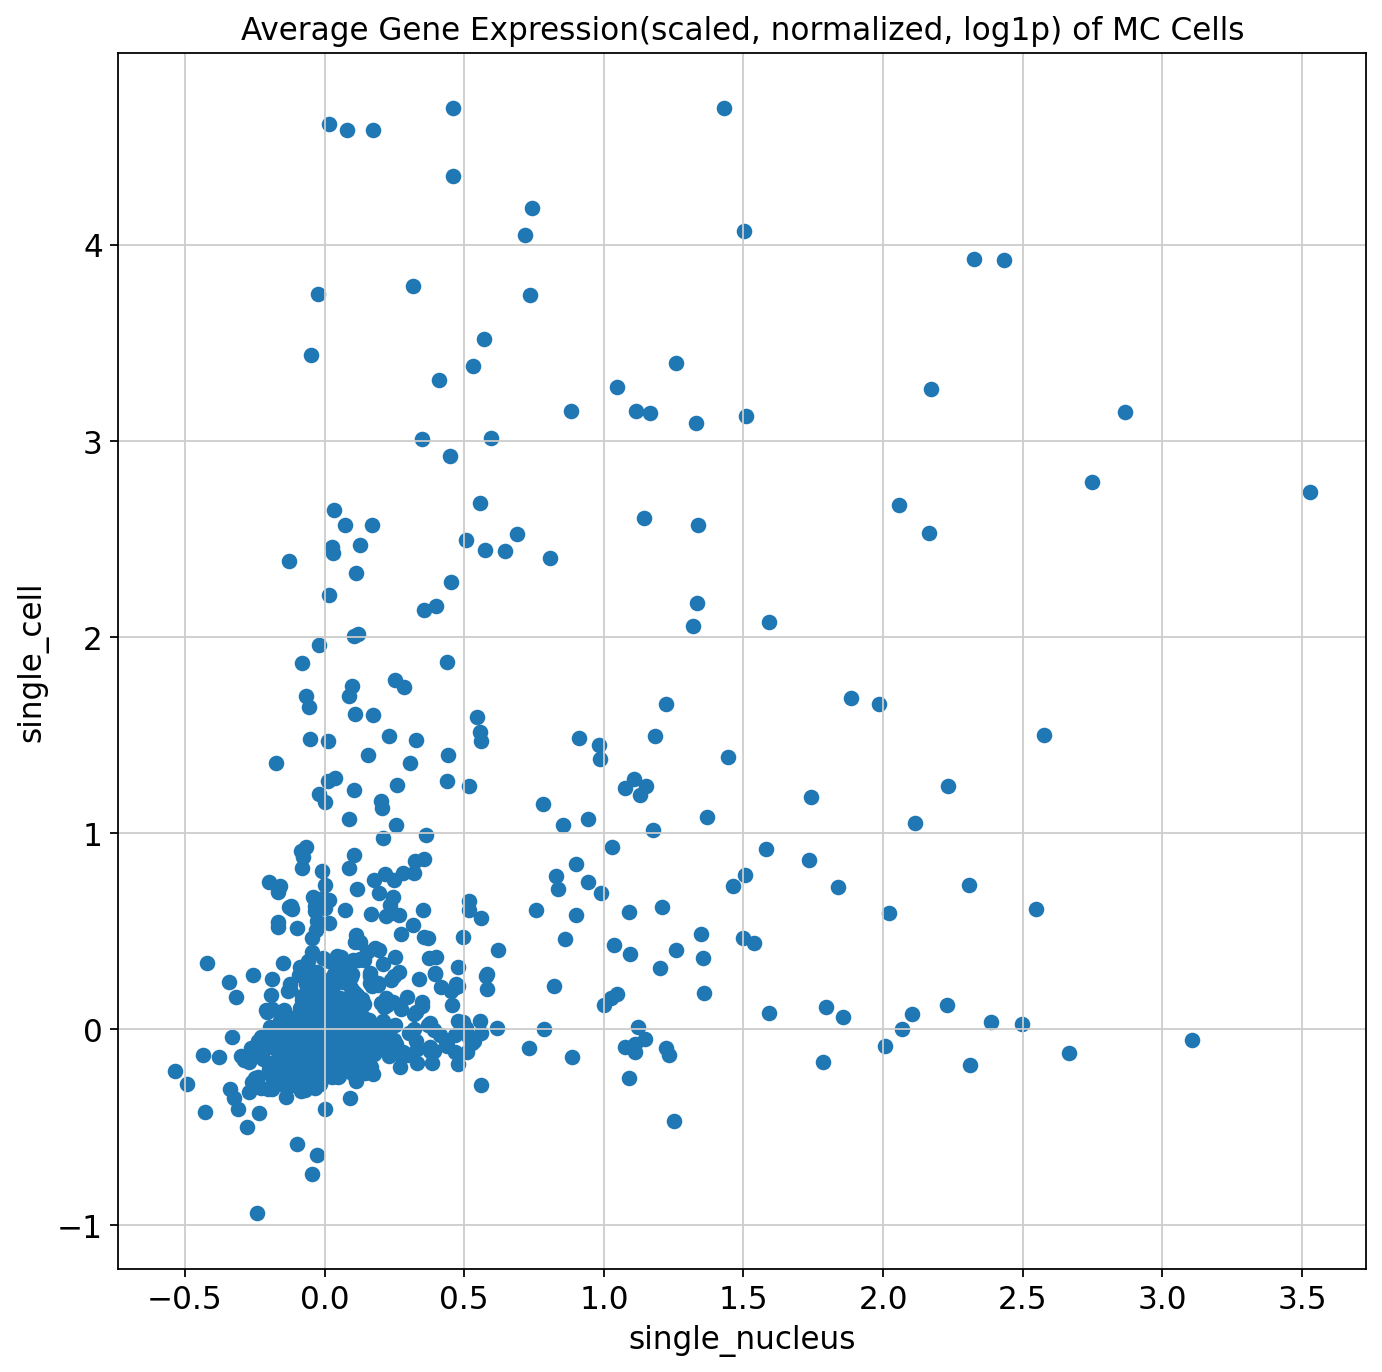

In [324]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_MC"], y = av_df_celltype["single_cell_MC"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, log1p) of MC Cells")
plt.show()

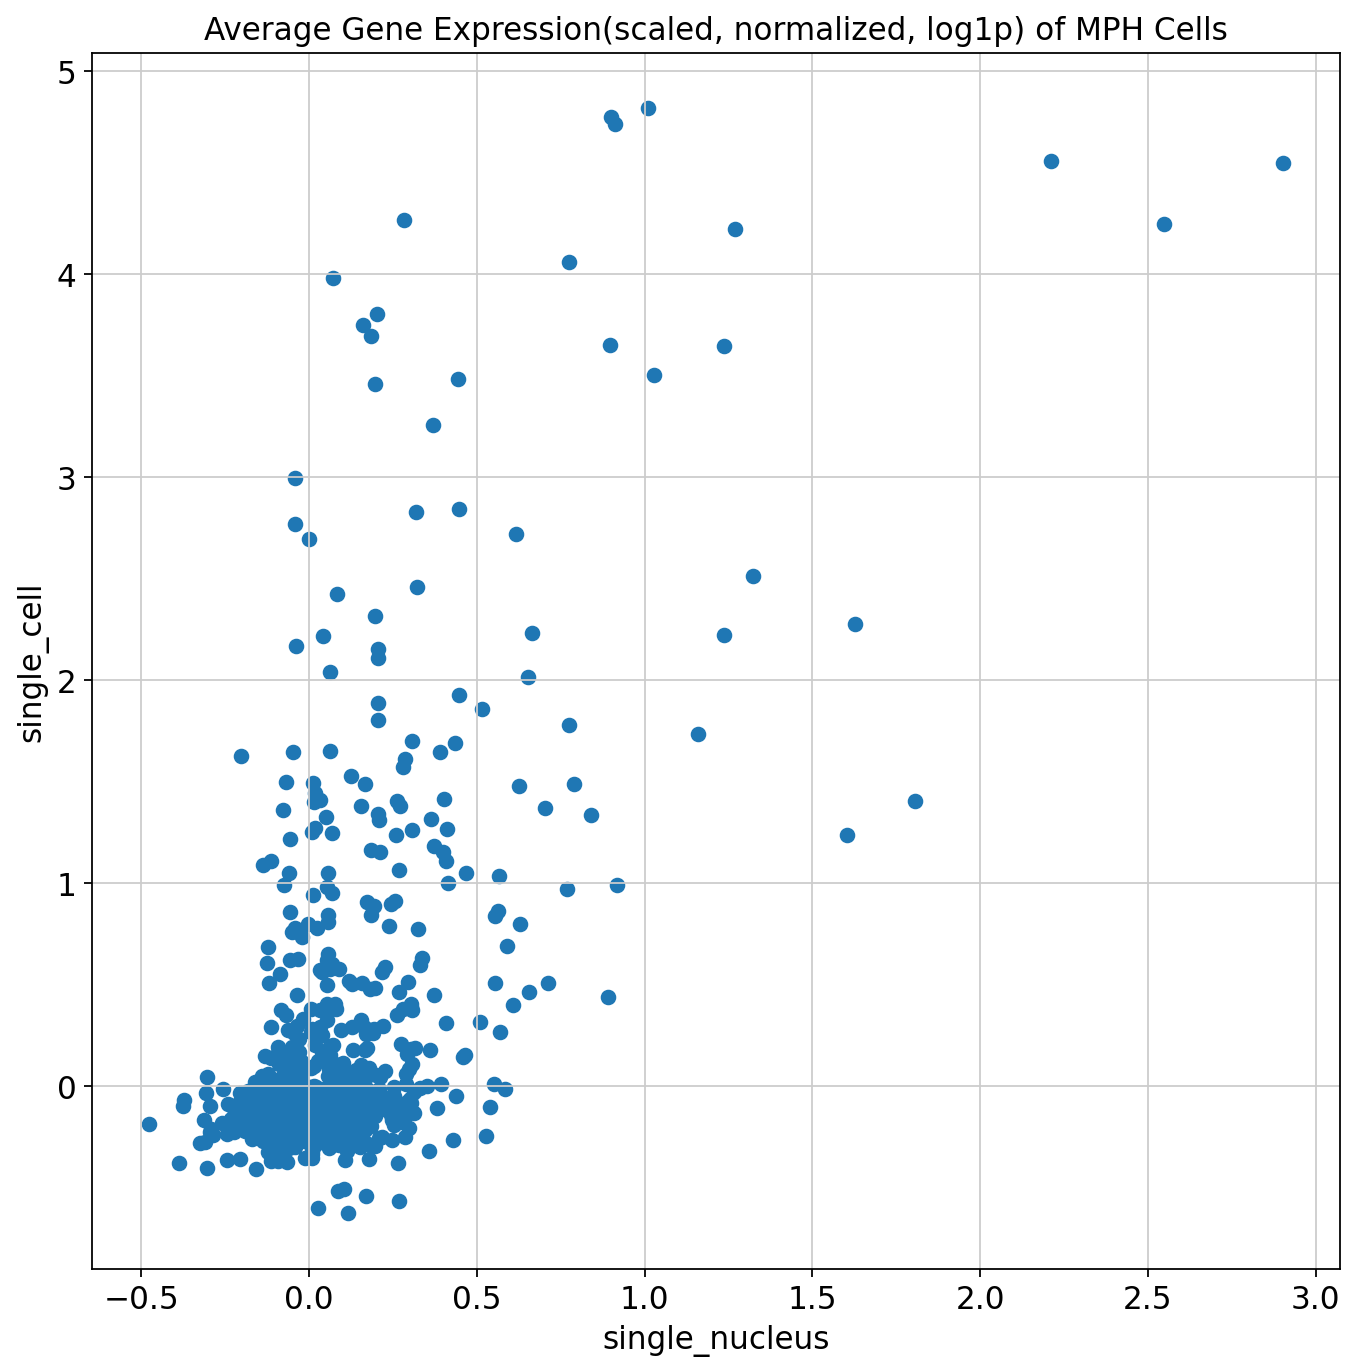

In [325]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_MPH"], y = av_df_celltype["single_cell_MPH"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, log1p) of MPH Cells")
plt.show()

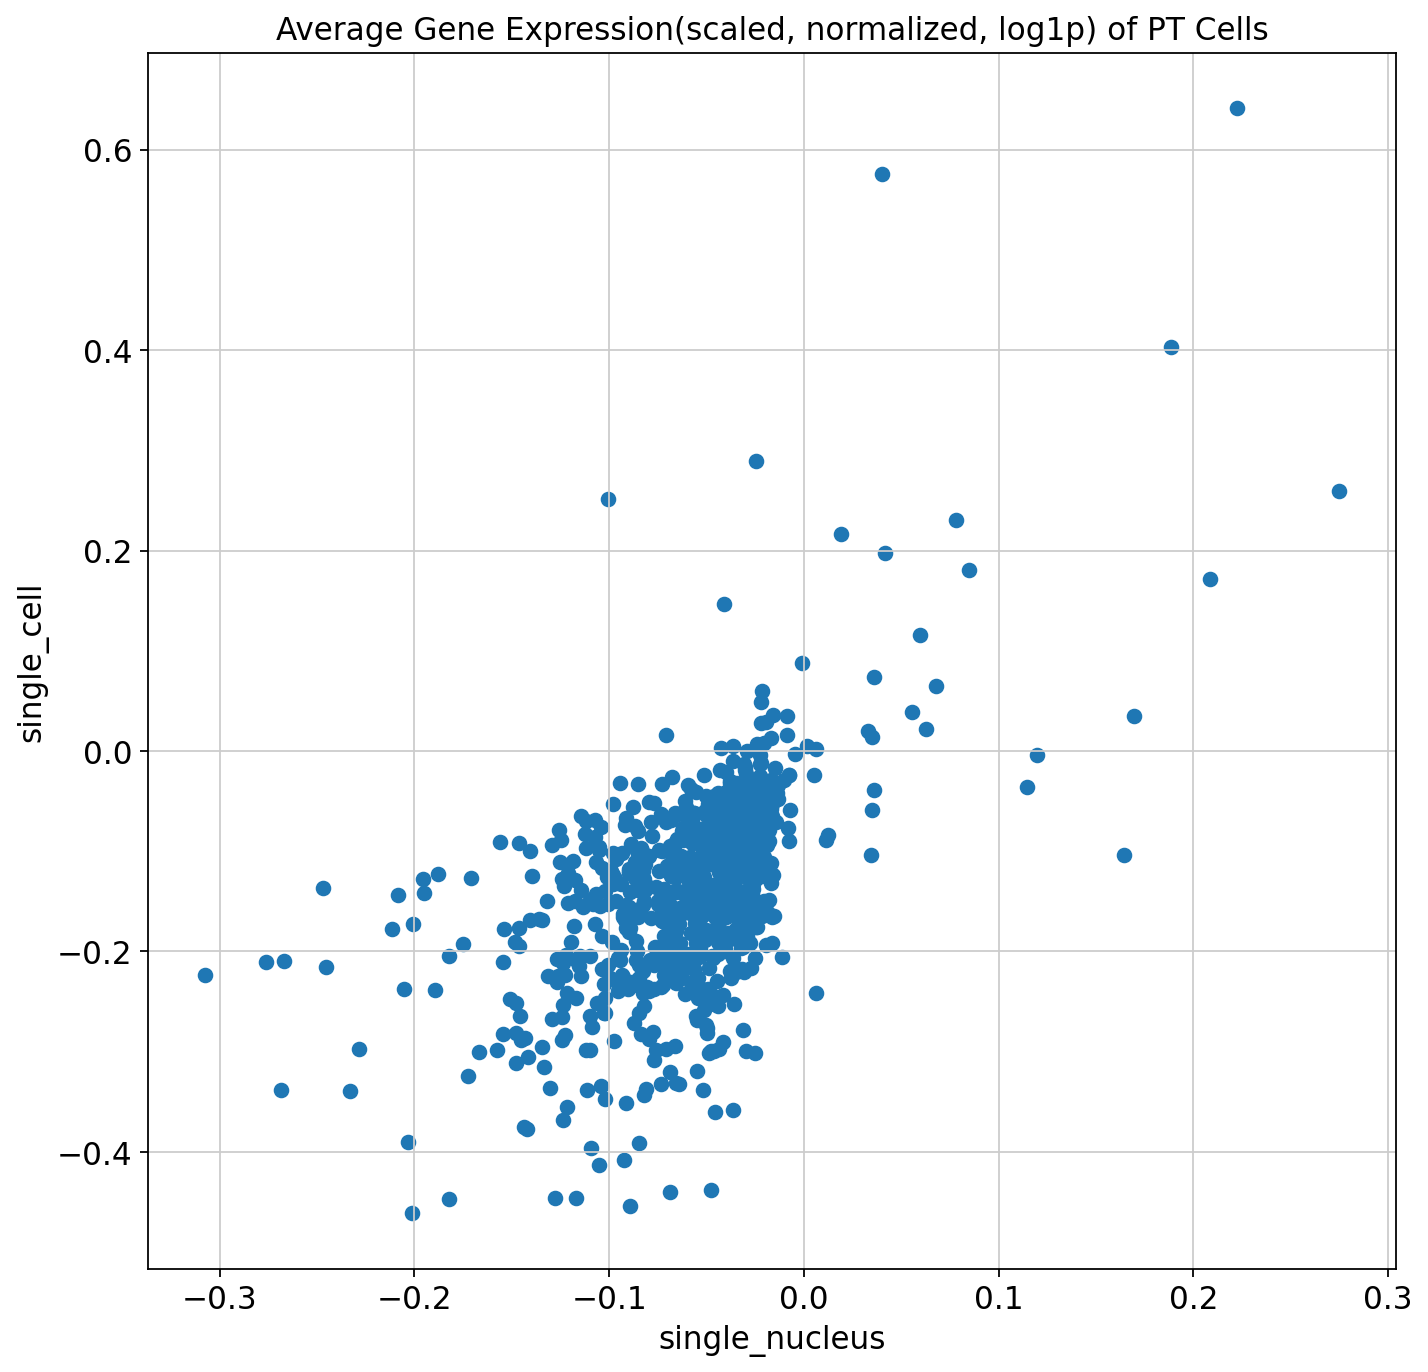

In [326]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_PT"], y = av_df_celltype["single_cell_PT"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, log1p) of PT Cells")
plt.show()

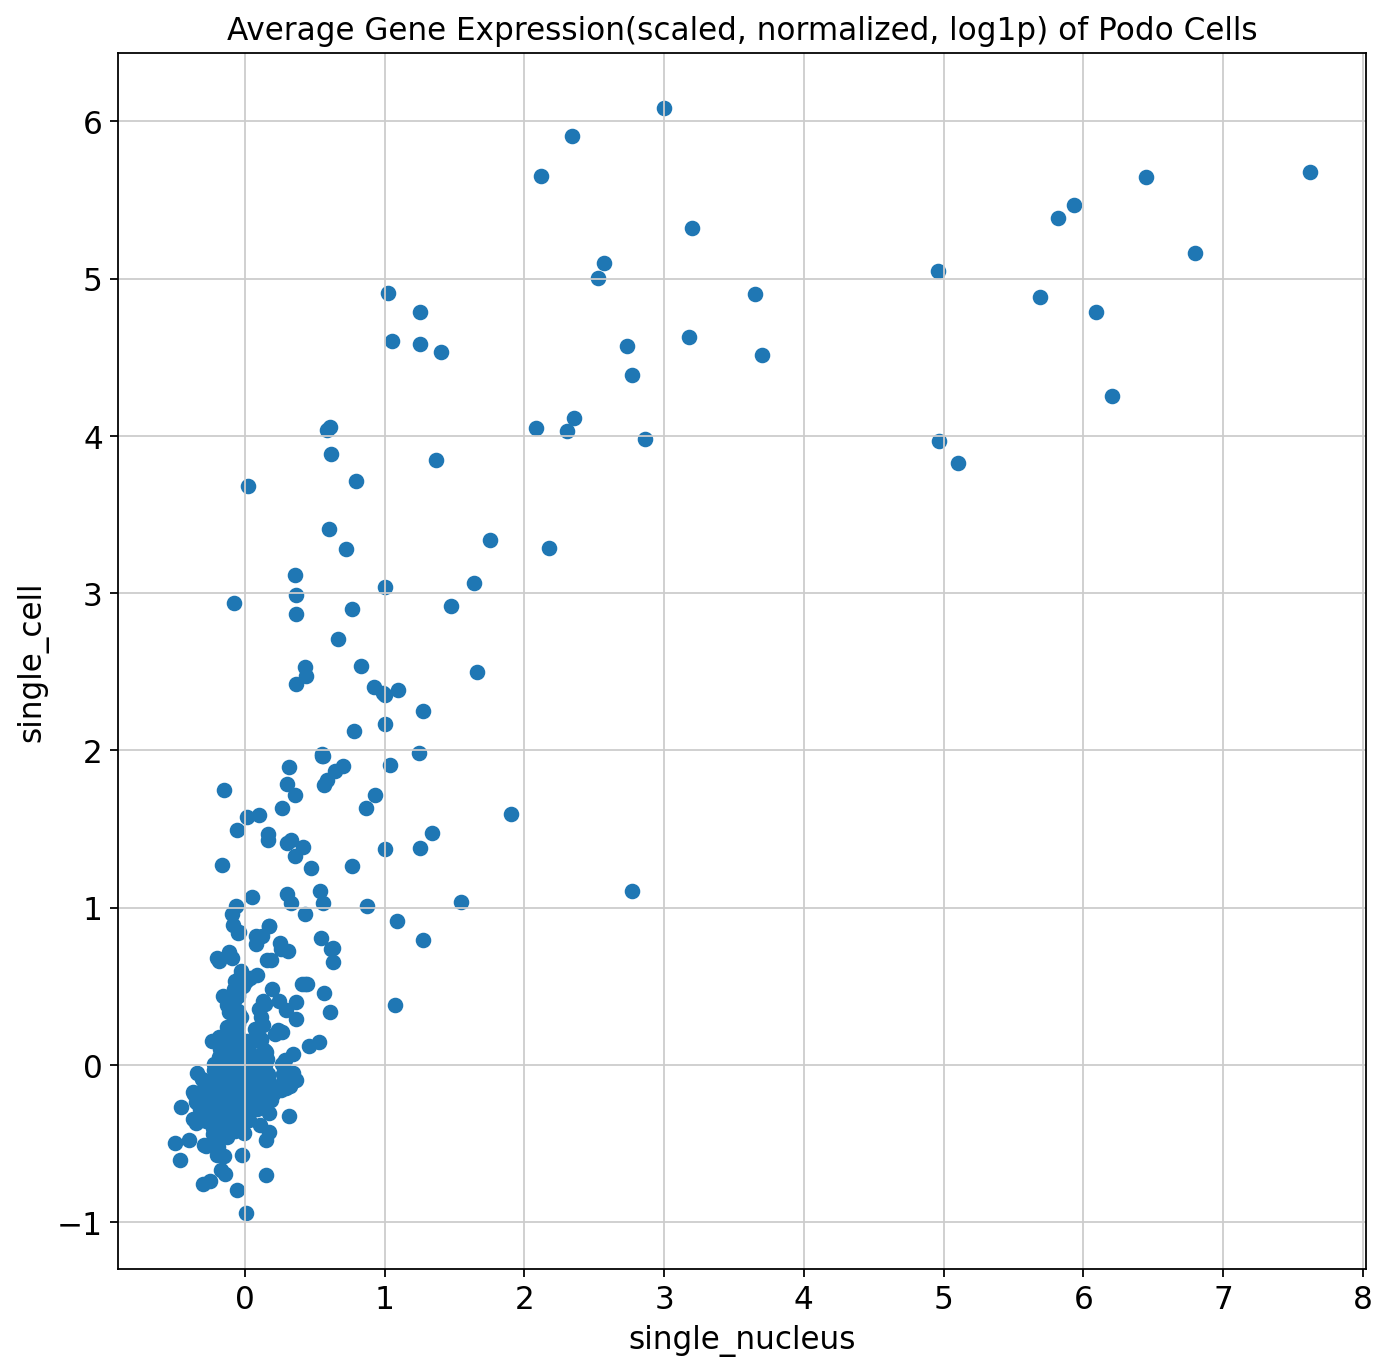

In [327]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_Podo"], y = av_df_celltype["single_cell_Podo"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, log1p) of Podo Cells")
plt.show()

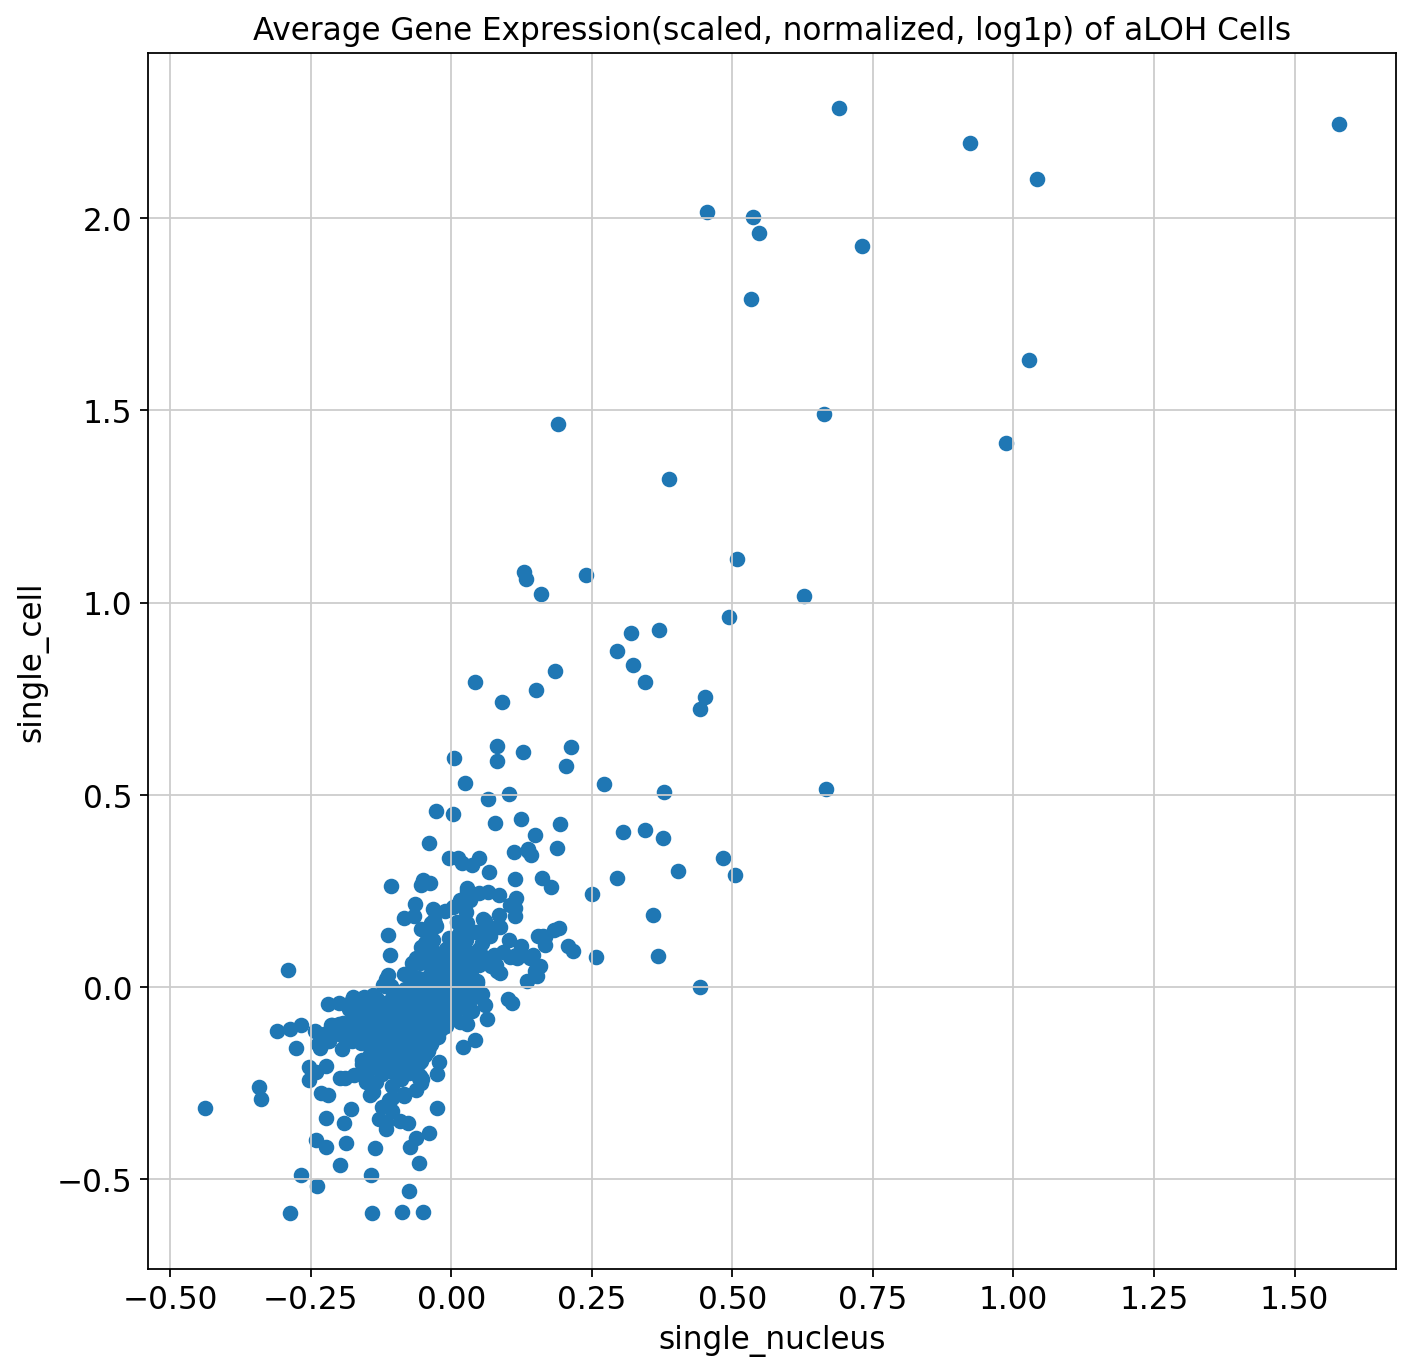

In [328]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_aLOH"], y = av_df_celltype["single_cell_aLOH"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, log1p) of aLOH Cells")
plt.show()

In [257]:
#funtion from https://github.com/greenelab/sc_bulk_ood/blob/main/evaluation_experiments/pbmc/pbmc_experiment_perturbation.ipynb
def mean_sqr_error(single1, single2):
  return np.mean((single1 - single2)**2)

In [258]:
single_df = pd.DataFrame(single_adata_inner.X, columns = single_adata_inner.var_names, index = single_adata_inner.obs['orig_and_celltype'])
single_df

Sox17     Prex2      Mcm3    Ptpn18    Neurl3  \
orig_and_celltype                                                       
single_nucleus_aLOH -0.119656 -0.296922 -0.090672 -0.372847 -0.128516   
single_nucleus_aLOH -0.119932 -0.297184 -0.056979 -0.400118 -0.096829   
single_nucleus_aLOH -0.113349 -0.284839 -0.073576  4.604863 -0.109545   
single_nucleus_PT   -0.067943 -0.198358 -0.016322 -0.220254 -0.035113   
single_nucleus_aLOH -0.103339 -0.265765 -0.059839 -0.330421 -0.092083   
...                       ...       ...       ...       ...       ...   
single_cell_PT      -0.186439 -0.179691 -0.108564 -0.362973 -0.157816   
single_cell_CNT     -0.192820 -0.220064 -0.091515 -0.286338 -0.176289   
single_cell_aLOH    -0.164214 -0.209394 -0.075825 -0.309454 -0.151793   
single_cell_Endo    -0.158177 -0.214835 -0.068353 -0.299859 -0.149256   
single_cell_PT      -0.191148 -0.208279 -0.096634 -0.308688 -0.171036   

                       Map4k4      Fhl2    Col5a2     Myo1b     Pgap1  ...  \
orig_and_celltype                                                      ...   
single_nucleus_aLOH -0.188576 -0.272775 -0.297282 -0.264407 -0.285667  ...   
single_nucleus_aLOH -0.181764 -0.246714 -0.245822 -0.243111 -0.285800  ...   
single_nucleus_aLOH -0.185378 -0.247768 -0.260755 -0.241471 -0.284119  ...   
single_nucleus_PT   -0.175641 -0.119632 -0.099191 -0.118968 -0.272851  ...   
single_nucleus_aLOH -0.183006 -0.218640  5.319784 -0.213742 -0.281637  ...   
...                       ...       ...       ...       ...       ...  ...   
single_cell_PT      -0.255303 -0.147016 -0.144682 -0.154626 -0.289982  ...   
single_cell_CNT     -0.195708 -0.126614 -0.133806 -0.132245 -0.125220  ...   
single_cell_aLOH    -0.172571 -0.108389 -0.204915 -0.117288 -0.151323  ...   
single_cell_Endo    -0.154575 -0.099588 -0.220934 -0.108923 -0.124647  ...   
single_cell_PT      -0.213378 -0.132736 -0.136499 -0.138926 -0.173438  ...   

                      Cables1    Pcdh12    Dpysl3    Gm4951    Piezo2  \
orig_and_celltype                                                       
single_nucleus_aLOH -0.188364 -0.133454 -0.106477 -0.120366 -0.178353   
single_nucleus_aLOH -0.155528 -0.119598 -0.121438 -0.113820 -0.169535   
single_nucleus_aLOH -0.172015 -0.123152 -0.110143 -0.112869 -0.171329   
single_nucleus_PT   -0.118438 -0.076329 -0.107636 -0.072035 -0.138205   
single_nucleus_aLOH -0.159118 -0.112367 -0.110080 -0.103645 -0.163731   
...                       ...       ...       ...       ...       ...   
single_cell_PT      -0.133759 -0.067994 -0.143434 -0.100746 -0.061507   
single_cell_CNT     -0.137966 -0.100786 -0.121208 -0.117433 -0.079657   
single_cell_aLOH    -0.182510 -0.098625 -0.095232 -0.110437 -0.076004   
single_cell_Endo    -0.194776 -0.104711 -0.084076 -0.112023 -0.078744   
single_cell_PT      -0.136415 -0.091168 -0.127921 -0.112580 -0.074351   

                     Ankrd13d     Cd248    Mamdc2      Pgm5     Cd274  
orig_and_celltype                                                      
single_nucleus_aLOH -0.080195 -0.074338 -0.064059 -0.082795 -0.073364  
single_nucleus_aLOH -0.076245 -0.105765 -0.047581 -0.084001 -0.064966  
single_nucleus_aLOH -0.074500 -0.085292 -0.055062 -0.080444 -0.069426  
single_nucleus_PT   -0.041530 -0.103171 -0.022535 -0.061415 -0.057453  
single_nucleus_aLOH -0.067096 -0.090266 -0.047345 -0.076285 -0.066509  
...                       ...       ...       ...       ...       ...  
single_cell_PT      -0.076898 -0.085833 -0.067946 -0.081537 -0.079635  
single_cell_CNT     -0.067662 -0.080832 -0.060391 -0.058867 -0.079241  
single_cell_aLOH    -0.063085 -0.064911 -0.043064 -0.064885 -0.078724  
single_cell_Endo    -0.060042 -0.059818 -0.037095 -0.061837 -0.078512  
single_cell_PT      -0.070408 -0.082414 -0.062733 -0.065484 -0.079361  

[13168 rows x 955 columns]

In [262]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in single_df.columns:
    for cell in matching_celltypes:
        #mean of all the expression of celltype in gene in sc and sn
        sc_val = np.mean(single_df.loc[f"single_cell_{cell}"][gene])
        sn_val = np.mean(single_df.loc[f"single_nucleus_{cell}"][gene])
        #adding mse to another dataframe
        mse_df.loc[cell][gene] = mean_sqr_error(sc_val, sn_val)
mse_df

1700025G04Rik 1700040L02Rik 1700066B19Rik 1810011O10Rik 2010007H06Rik  \
CD_IC      0.009754      0.030721      0.003397       0.01916       0.00078   
CD_PC      0.002342      0.011255       0.00522      0.010246      0.001093   
CNT         0.00274      0.009899       0.02828      0.012851      0.034762   
DCT        0.009768       0.05936      0.032735      0.004223      0.018349   
Endo       0.066675      0.020928      0.000076      1.511282      0.020904   
MC         0.053819      0.016814      0.000683      0.018175      0.000041   
MPH        0.033553      0.005929      0.020011      0.037959      0.000711   
PT         0.010257      0.001648      0.000005      0.030214      0.000642   
Podo       0.551707        0.0192      0.003541      0.106949      0.021566   
aLOH       0.000023      0.000127       0.00101      0.199529      0.002117   

      2700033N17Rik 2700081O15Rik 3110099E03Rik 4632411P08Rik 4833403J16Rik  \
CD_IC      0.000425      0.022284      0.000083      0.017313      0.001878   
CD_PC      0.001596      0.026725      0.000662      0.003835      0.002479   
CNT        0.007988      0.004645      0.002544      0.000481      0.003984   
DCT        0.001196       0.00823      0.000225      0.006664      0.000001   
Endo       0.493601      0.109069      0.170914      0.000049      0.541521   
MC         0.001008      0.002339      0.001863      0.000153      0.002641   
MPH        0.026522      0.017634      0.055069      0.010445       0.03464   
PT         0.001123      0.001208       0.00339      0.000135      0.004322   
Podo       0.053298      0.062461      0.000451      0.049376      0.000926   
aLOH       0.000143      0.002499      0.000046      0.000178      0.000008   

       ...    Zbtb42   Zdhhc18     Zfhx3     Zfp13    Zfp334   Zfp385b  \
CD_IC  ...  0.032104  0.180382  0.352226  0.004753  0.000135  0.071084   
CD_PC  ...  0.015604  0.001245  0.002788   0.10401  0.013433  0.000061   
CNT    ...  0.000033  0.035561  0.084085  0.000184  0.006919  0.000272   
DCT    ...  0.015439  0.005606   0.00727  0.000083   0.00464  0.006994   
Endo   ...   0.00019  0.301831  0.012367  0.011691  0.000001  0.000006   
MC     ...  0.016274  0.003834  5.765621  0.002205  0.003665   0.00112   
MPH    ...  0.000119  0.032381  0.128689  0.008278  0.015448  0.024601   
PT     ...  0.003077   0.01143  0.017848  0.002233  0.000066  0.002483   
Podo   ...  0.036336  0.000442  0.069598  0.005643   0.00016  2.772932   
aLOH   ...  0.002717  0.013748  0.000235  0.001663  0.001738   0.00551   

         Zfp521    Zfp658    Zfp711      Zfr2  
CD_IC  0.000004  0.001049  0.000129   0.00896  
CD_PC  0.001456  0.005272  0.000249  0.019681  
CNT    0.004901  0.000787  0.002054  0.002901  
DCT    0.006325  0.002831  0.000557  0.017516  
Endo   0.066268  0.005296  0.018852       0.0  
MC     0.022323     0.001  0.001858  0.041948  
MPH    0.013225  0.234815  0.003017  0.033422  
PT     0.000631  0.001238  0.000065  0.000536  
Podo   0.011572  0.001068  0.000393  0.049351  
aLOH   0.015242  0.003915  0.004793  0.022145  

[10 rows x 955 columns]

In [263]:
mse_df = mse_df.astype('float')
mse_df = mse_df.transpose()

In [264]:
#Saving mse df
pickle.dump(mse_df, open( f"{processed_path}mse_snsc_df_scaled.pkl", "wb" ) )

In [265]:
av_df_celltype = res_inner.transpose()

In [266]:
av_df_celltype

single_cell_CD_IC single_cell_CD_PC single_cell_CD_Trans  \
1700025G04Rik          0.086509         -0.103755            -0.150161   
1700040L02Rik          0.281462          0.183945            -0.366586   
1700066B19Rik         -0.058871           0.07642            -0.071097   
1810011O10Rik         -0.270011         -0.208539             0.251537   
2010007H06Rik          0.158357         -0.023302            -0.101565   
...                         ...               ...                  ...   
Zfp385b                0.100158         -0.136172            -0.171097   
Zfp521                 0.036316         -0.056103            -0.064448   
Zfp658                -0.066856          0.032417            -0.066914   
Zfp711                 0.034165          0.040515            -0.081747   
Zfr2                   0.147814          0.100807            -0.103526   

              single_cell_CNT single_cell_DCT single_cell_Endo  \
1700025G04Rik       -0.157095       -0.106779         0.921152   
1700040L02Rik        0.315371        0.535196        -0.126932   
1700066B19Rik       -0.028076       -0.035679        -0.044056   
1810011O10Rik       -0.228076       -0.158095         2.117623   
2010007H06Rik       -0.059362        0.125545         0.061194   
...                       ...             ...              ...   
Zfp385b             -0.095626       -0.053987         -0.13343   
Zfp521              -0.060891       -0.031047         0.038094   
Zfp658              -0.066106       -0.034332           0.0527   
Zfp711               -0.02736       -0.101634         0.046693   
Zfr2                -0.016585        0.224954        -0.059633   

              single_cell_Fib single_cell_MC single_cell_MPH single_cell_NK  \
1700025G04Rik        0.301335       0.359697        0.176239       0.941271   
1700040L02Rik       -0.266794      -0.104853       -0.181448      -0.209456   
1700066B19Rik       -0.037138      -0.037091        0.031051      -0.039553   
1810011O10Rik       -0.179346       0.059628       -0.244451      -0.268104   
2010007H06Rik        -0.11571      -0.019971       -0.007007       -0.07505   
...                       ...            ...             ...            ...   
Zfp385b             -0.215404      -0.140668       -0.147607      -0.149172   
Zfp521              -0.047415      -0.048299       -0.047198      -0.050078   
Zfp658               -0.07115      -0.069431        0.447958      -0.068091   
Zfp711              -0.054947      -0.042995       -0.030014      -0.037803   
Zfr2                -0.105555        0.17923        0.058619      -0.074795   

               ... single_nucleus_CD_PC single_nucleus_CNT single_nucleus_DCT  \
1700025G04Rik  ...            -0.055362          -0.104748          -0.007945   
1700040L02Rik  ...             0.077858           0.215876           0.291556   
1700066B19Rik  ...             0.004168           0.140091           0.145249   
1810011O10Rik  ...            -0.107314          -0.114716          -0.093114   
2010007H06Rik  ...             0.009765           0.127085          -0.009913   
...            ...                  ...                ...                ...   
Zfp385b        ...            -0.143987          -0.079147           0.029645   
Zfp521         ...            -0.094265            -0.1309           -0.11058   
Zfp658         ...            -0.040189          -0.038046           0.018877   
Zfp711         ...             0.024723            0.01796          -0.078035   
Zfr2           ...             0.241096           0.037273           0.092606   

              single_nucleus_Endo single_nucleus_MC single_nucleus_MPH  \
1700025G04Rik            0.662938          0.127707           0.359413   
1700040L02Rik           -0.271596         -0.234522          -0.258448   
1700066B19Rik           -0.035319         -0.063224          -0.110409   
1810011O10Rik            0.888282         -0.075185          -0.049621   
2010007H06Rik           -0.083387       

In [267]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
df = pd.DataFrame(columns =["SC", "SN"], index = res_inner.columns)
for cell in matching_celltypes:
        #mean of all the expression of celltype in gene in sc and sn
    sc_val = av_df_celltype[f"single_cell_{cell}"]
    sn_val = av_df_celltype[f"single_nucleus_{cell}"]
    corr = pearsonr(sc_val, sn_val)[0]
    pearson_df_snsc[cell] = corr


In [296]:
pearson_df_snsc.values[0]

array([0.81476283, 0.81301851, 0.63408211, 0.82787265, 0.86715568,
       0.43818029, 0.60525435, 0.57261332, 0.81136518, 0.82764526])

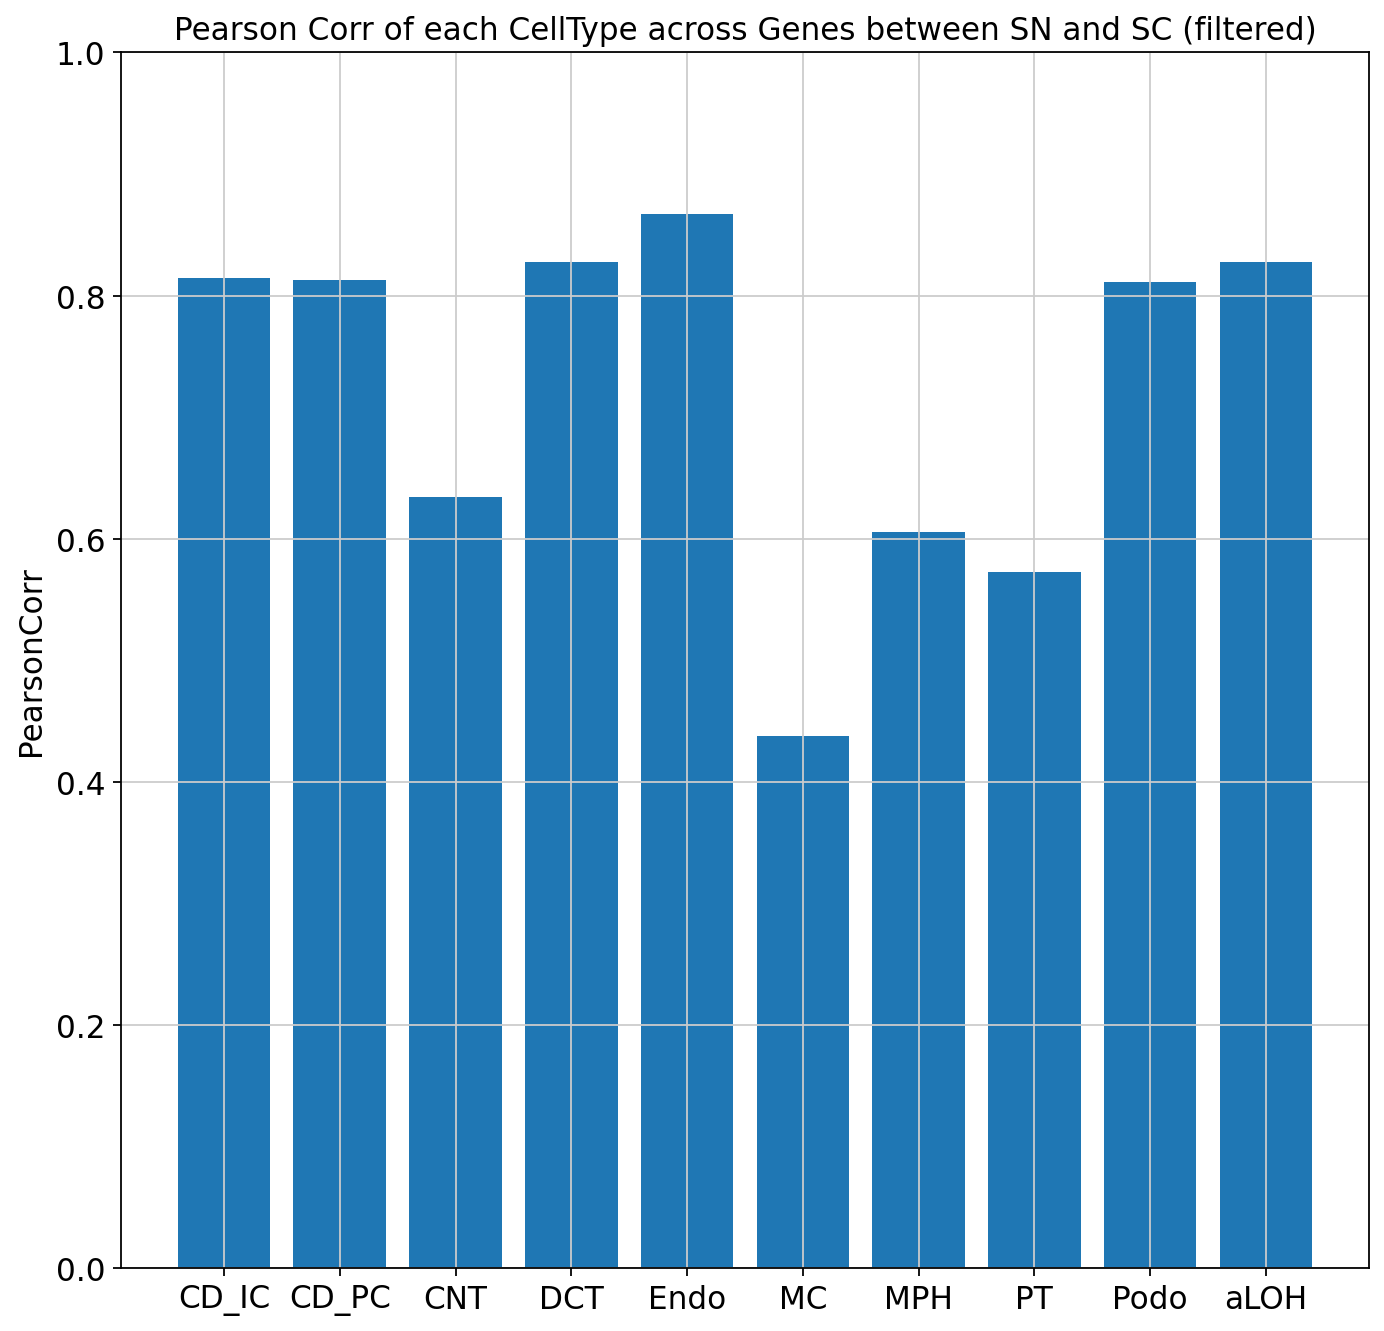

In [305]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
titles = pearson_df_snsc.columns
counts = pearson_df_snsc.values[0]
bar_labels = pearson_df_snsc.columns

ax.bar(titles, counts, label=bar_labels)
ax.set_ylim([0,1])
ax.set_ylabel('PearsonCorr')
ax.set_title('Pearson Corr of each CellType across Genes between SN and SC (filtered)')

plt.show()

Text(0.5, 1.0, 'MSE of Average SN vs. Average SC per Common Gene')

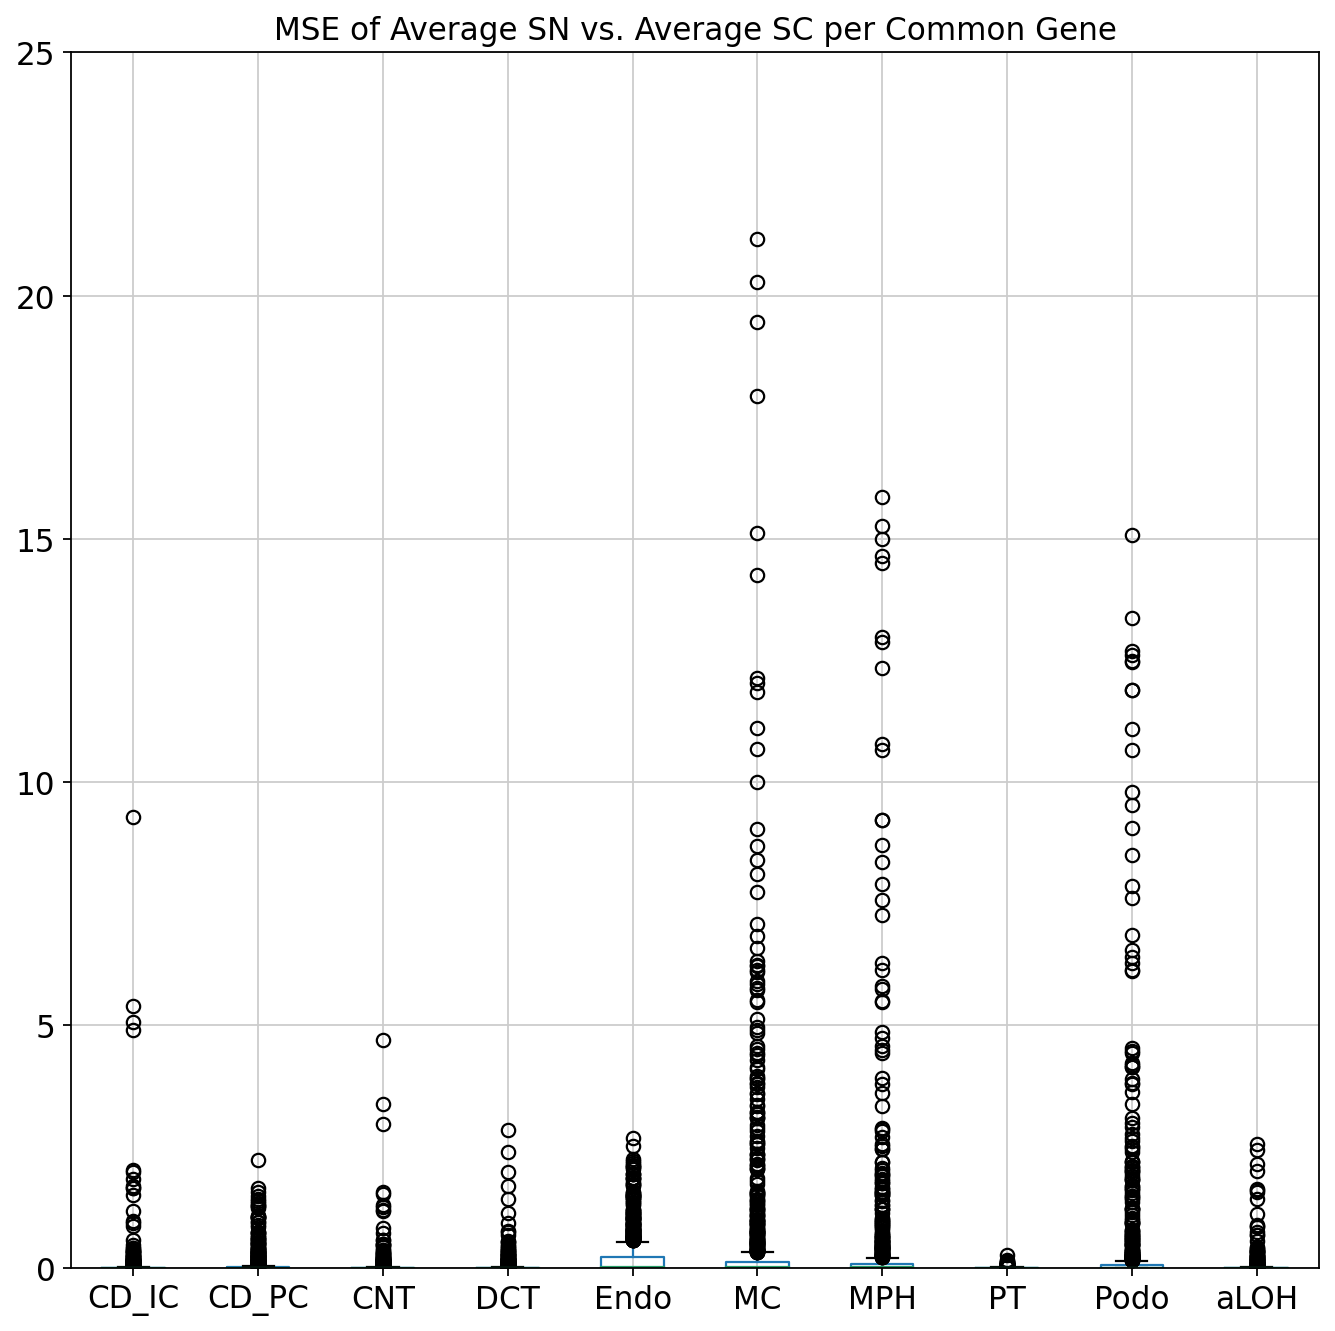

In [311]:
plt.figure(figsize= [10,10])
ax = mse_df.boxplot(column = ['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH'])
ax.set_ylim([0,25])
plt.title('MSE of Average SN vs. Average SC per Common Gene')

Tryign linear regression model with the first cell type:

In [ ]:
def linear_modeling(adata, obs_var, obs_cat_X, obs_cat_Y, train_pc):
    #based on https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

    #extracting data from adata object:
    x = adata[adata.obs[obs_var]==obs_cat_X].X
    y = adata[adata.obs[obs_var]==obs_cat_Y].X

    # makign number of cells the same:
    if x.shape[0] > y.shape[0]:
        x = x[0:y.shape[0]]
    else:
        y = y[0:x.shape[0]]

    #divide into test and training:
    y_train = y[0:y.shape[1]*train_pc]
    y_test = y[y.shape[1]*train_pc:-1]
    x_train = x[0:x.shape[1]*train_pc]
    x_test = x[x.shape[1]*train_pc:-1]

    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(x_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(x_test)

    # The coefficients
    print("Coefficients: \n", regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

    # Plot outputs
    plt.scatter(x_test, y_test, color="black")
    plt.plot(x_test, y_pred, color="blue", linewidth=3)

    plt.xticks(())
    plt.yticks(())

    plt.show()
    return(regr, x_train, y_train, x_test, y_test, y_pred)
    

In [ ]:
#Code based from https://github.com/scverse/anndata/issues/73 falexwolf commented on Oct 20, 2018
#trimming down the bulk data to contain only genes available in common_genes SN and SC
common_gene_indicator_bulk = np.in1d(bulk_adata.var_names, common_genes_wbulk)
bulk_adata = bulk_adata[:, common_gene_indicator_bulk]
bulk_adata

View of AnnData object with n_obs × n_vars = 1 × 955
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [ ]:
bulk_adata_df = pd.DataFrame(bulk_adata.X, columns=bulk_adata.var_names)
#reordering columsn so they match    
bulk_adata_df= bulk_adata_df.reindex(sorted(bulk_adata_df.columns), axis=1)
bulk_adata_df

1700025G04Rik  1700040L02Rik  1700066B19Rik  1810011O10Rik  2010007H06Rik  \
0       0.096612       0.210833       0.000909       0.244163       0.057878   

   2700033N17Rik  2700081O15Rik  3110099E03Rik  4632411P08Rik  4833403J16Rik  \
0       0.015795       0.197855       0.030903       0.006348       0.005896   

   ...    Zbtb42   Zdhhc18     Zfhx3     Zfp13    Zfp334  Zfp385b    Zfp521  \
0  ...  0.098262  0.304651  0.135094  0.091644  0.072368  0.21561  0.033545   

    Zfp658    Zfp711     Zfr2  
0  0.03002  0.031784  0.09991  

[1 rows x 955 columns]

In [ ]:
#trimming down the sn and sc data  to contain only genes available in bulk as well.
sn_adata = sn_adata[:, common_genes_wbulk]
sc_adata = sc_adata[:, common_genes_wbulk]

In [ ]:
av_per_gene_sn = pd.DataFrame(columns=sn_adata.var_names, index = [1])
av_per_gene_sc = pd.DataFrame(columns=sn_adata.var_names, index = [1])

In [ ]:
for gene in sn_adata.var_names:
    sum_per_gene = 0 
    for cell in matching_celltypes: 
        sum_per_gene = sum_per_gene + res_inner.loc[f"single_nucleus_{cell}"][gene] 
    av_per_gene_sn[gene] = sum_per_gene / len(matching_celltypes)
av_per_gene_sn    

1700025G04Rik  1700040L02Rik  1700066B19Rik  1810011O10Rik  2010007H06Rik  \
1       0.108894       -0.00376      -0.005374        0.03679       0.025087   

   2700033N17Rik  2700081O15Rik  3110099E03Rik  4632411P08Rik  4833403J16Rik  \
1        0.00887       0.039884       0.022462       0.000422      -0.014007   

   ...    Zbtb42   Zdhhc18     Zfhx3     Zfp13    Zfp334   Zfp385b    Zfp521  \
1  ... -0.030882  0.085652  0.197754 -0.019067 -0.020647  0.275073  0.087152   

     Zfp658    Zfp711      Zfr2  
1 -0.027411 -0.029301  0.018919  

[1 rows x 955 columns]

In [ ]:
for gene in sc_adata.var_names:
    sum_per_gene = 0 
    for cell in matching_celltypes: 
        sum_per_gene = sum_per_gene + res_inner.loc[f"single_cell_{cell}"][gene] 
    av_per_gene_sc[gene] = sum_per_gene / len(matching_celltypes)
av_per_gene_sc   

1700025G04Rik  1700040L02Rik  1700066B19Rik  1810011O10Rik  2010007H06Rik  \
1       0.173436       0.074783      -0.013653       0.106507       0.019289   

   2700033N17Rik  2700081O15Rik  3110099E03Rik  4632411P08Rik  4833403J16Rik  \
1       0.019931        0.02653       0.029761      -0.012586       0.010756   

   ...  Zbtb42   Zdhhc18     Zfhx3     Zfp13    Zfp334   Zfp385b    Zfp521  \
1  ...  0.0443  0.077407  0.341438  0.027338 -0.010787  0.050936  0.032954   

     Zfp658    Zfp711      Zfr2  
1  0.020528 -0.004114  0.065983  

[1 rows x 955 columns]

In [ ]:
mse_df_snbulk = pd.DataFrame(columns=sn_adata.var_names, index = [1])
mse_df_scbulk = pd.DataFrame(columns=sn_adata.var_names, index = [1])

In [ ]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in bulk_adata_df.columns:
    val = mean_sqr_error(av_per_gene_sc[gene].values[0], bulk_adata_df[gene].values[0])
    mse_df_scbulk[gene] = val
mse_df_scbulk

1700025G04Rik  1700040L02Rik  1700066B19Rik  1810011O10Rik  2010007H06Rik  \
1       0.005902        0.01851       0.000212       0.018949       0.001489   

   2700033N17Rik  2700081O15Rik  3110099E03Rik  4632411P08Rik  4833403J16Rik  \
1       0.000017       0.029352       0.000001       0.000359       0.000024   

   ...    Zbtb42  Zdhhc18     Zfhx3     Zfp13    Zfp334   Zfp385b  \
1  ...  0.002912  0.05164  0.042578  0.004135  0.006915  0.027117   

         Zfp521   Zfp658    Zfp711      Zfr2  
1  3.496847e-07  0.00009  0.001289  0.001151  

[1 rows x 955 columns]

In [ ]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in bulk_adata_df.columns:
    mse_df_snbulk[gene] = mean_sqr_error(av_per_gene_sn[gene].values[0], bulk_adata_df[gene].values[0])
mse_df_snbulk

1700025G04Rik  1700040L02Rik  1700066B19Rik  1810011O10Rik  2010007H06Rik  \
1       0.000151        0.04605       0.000039       0.043003       0.001075   

   2700033N17Rik  2700081O15Rik  3110099E03Rik  4632411P08Rik  4833403J16Rik  \
1       0.000048       0.024955       0.000071       0.000035       0.000396   

   ...    Zbtb42   Zdhhc18     Zfhx3     Zfp13    Zfp334   Zfp385b    Zfp521  \
1  ...  0.016678  0.047961  0.003926  0.012257  0.008652  0.003536  0.002874   

     Zfp658    Zfp711     Zfr2  
1  0.003298  0.003731  0.00656  

[1 rows x 955 columns]

In [ ]:
frames = [mse_df_snbulk, mse_df_scbulk]
mse_both = pd.concat(frames, keys=['single_nucleus', 'single_cell'])
mse_both

1700025G04Rik  1700040L02Rik  1700066B19Rik  1810011O10Rik  \
single_nucleus 1       0.000151        0.04605       0.000039       0.043003   
single_cell    1       0.005902        0.01851       0.000212       0.018949   

                  2010007H06Rik  2700033N17Rik  2700081O15Rik  3110099E03Rik  \
single_nucleus 1       0.001075       0.000048       0.024955       0.000071   
single_cell    1       0.001489       0.000017       0.029352       0.000001   

                  4632411P08Rik  4833403J16Rik  ...    Zbtb42   Zdhhc18  \
single_nucleus 1       0.000035       0.000396  ...  0.016678  0.047961   
single_cell    1       0.000359       0.000024  ...  0.002912  0.051640   

                     Zfhx3     Zfp13    Zfp334   Zfp385b        Zfp521  \
single_nucleus 1  0.003926  0.012257  0.008652  0.003536  2.873734e-03   
single_cell    1  0.042578  0.004135  0.006915  0.027117  3.496847e-07   

                    Zfp658    Zfp711      Zfr2  
single_nucleus 1  0.003298  0.003731  0.006560  
single_cell    1  0.000090  0.001289  0.001151  

[2 rows x 955 columns]

In [ ]:
mse_both = mse_both.transpose()

Text(0.5, 1.0, 'MSE of Bulk Expr. vs. Average Expr. in SN and SC (filtered)')

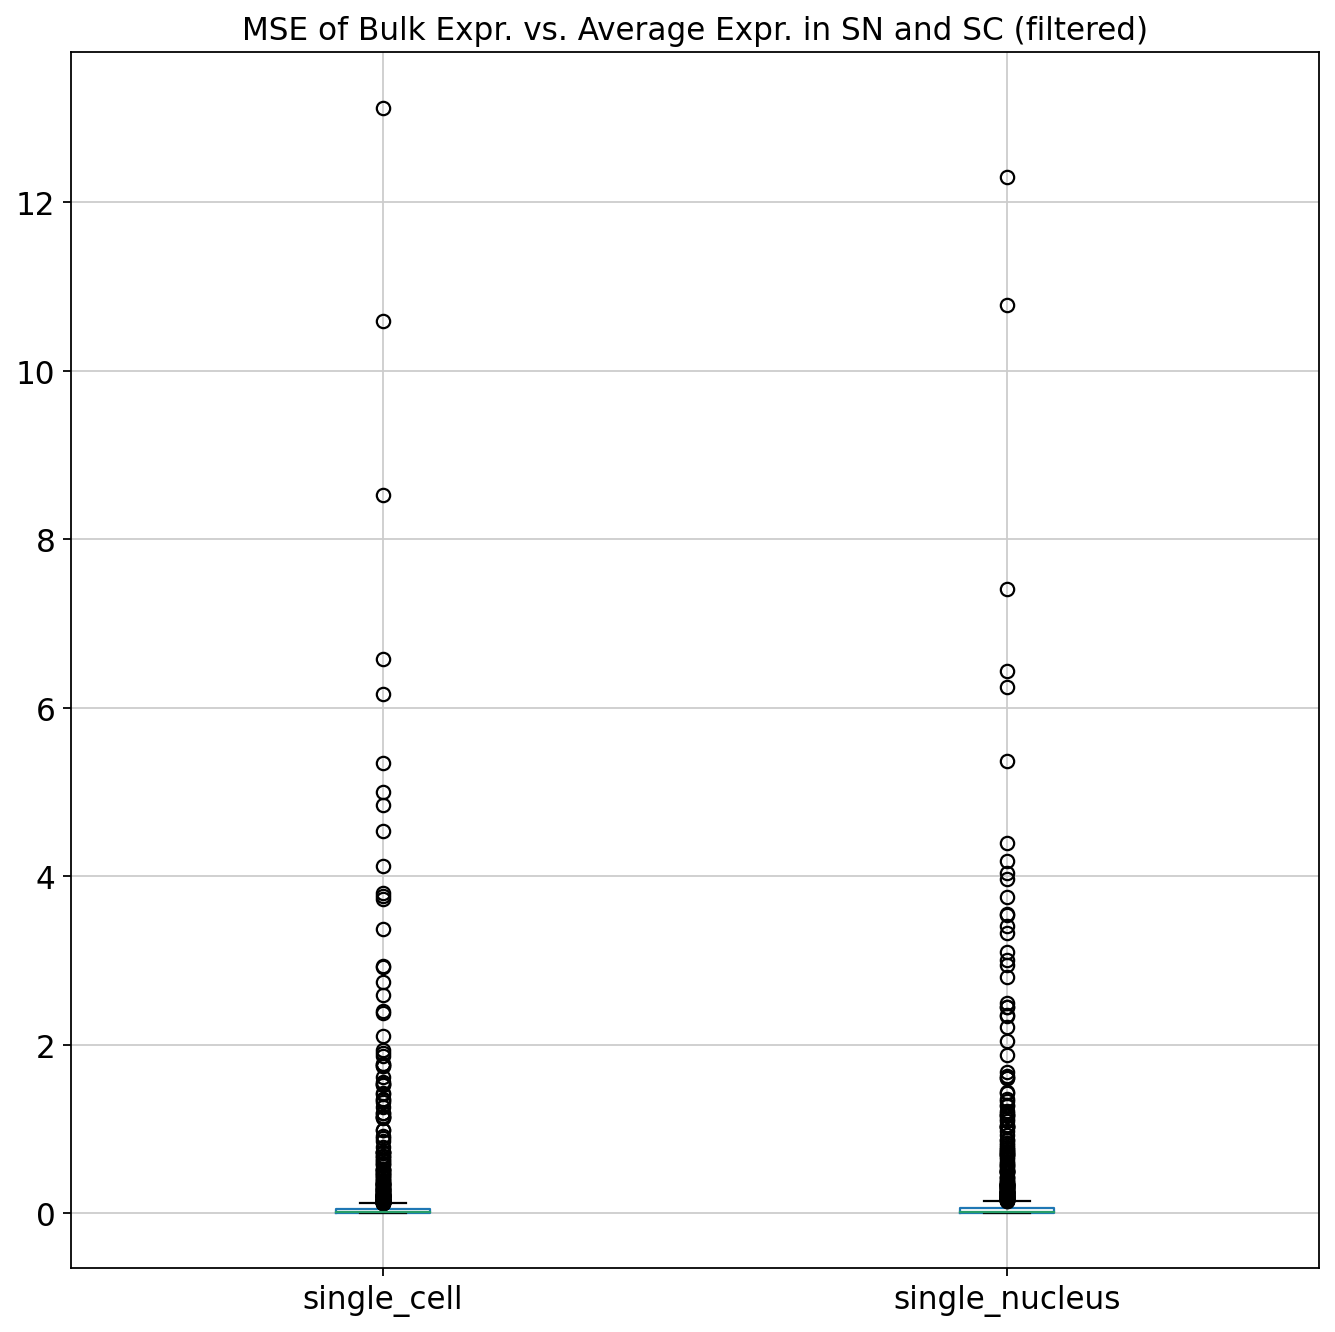

In [310]:
plt.figure(figsize= [10,10])
mse_both.boxplot(column = ['single_cell', 'single_nucleus'])
plt.title('MSE of Bulk Expr. vs. Average Expr. in SN and SC (filtered)')
#mean square error plot:

Doing PCA number of components analysis:

In [ ]:
pca_10 = PCA(n_components=10)
pca_X1 = pca_10.fit_transform(sn_adata.X) #sort of like the training dimensions
pca_X2 = pca_10.transform(sc_adata.X)  #fitting sc into sn dimensions
pca_X2

array([[ -3.3837447 ,   2.2973542 ,  10.286757  , ...,   1.8602471 ,
          3.797925  ,   0.59261554],
       [-16.598833  , -11.0189085 ,  -7.326261  , ...,  -1.3451372 ,
          0.0796885 ,  -8.100192  ],
       [  3.766697  ,   7.1760626 ,  18.752773  , ...,  -4.137359  ,
        -11.885546  ,  11.390489  ],
       ...,
       [-13.622611  ,  -8.81782   ,  -6.064151  , ...,  -0.35394892,
          1.989917  ,  -7.077202  ],
       [-19.757236  ,  -9.289225  , -10.817537  , ...,   0.16434114,
          0.9212719 , -11.365426  ],
       [ -6.2926908 ,  -8.177665  ,  -9.303875  , ...,   1.0793248 ,
         -0.54384   ,  -0.81692356]], dtype=float32)

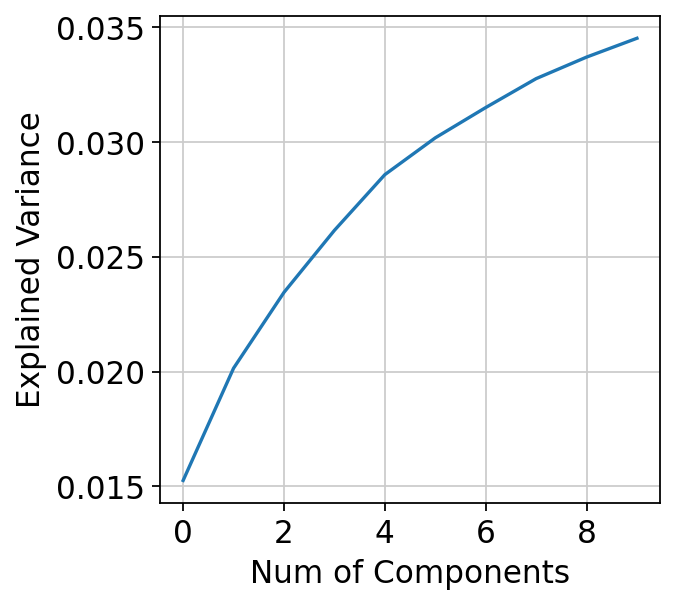

In [ ]:
plt.plot(np.cumsum(pca_10.explained_variance_ratio_))
plt.xlabel('Num of Components')
plt.ylabel('Explained Variance')
plt.show()

In [ ]:
pca_100 = PCA(n_components=100)
pca_X1 = pca_100.fit_transform(sn_adata.X) #sort of like the training dimensions
pca_X2 = pca_100.transform(sc_adata.X)  #fitting sc into sn dimensions
pca_X2

array([[-3.3837440e+00,  2.2973514e+00,  1.0286746e+01, ...,
         3.3998799e-01,  1.6081048e+00, -3.0110419e-01],
       [-1.6598827e+01, -1.1018907e+01, -7.3262529e+00, ...,
        -4.7391912e-01,  1.0056594e-01,  4.4368468e-02],
       [ 3.7666953e+00,  7.1760559e+00,  1.8752762e+01, ...,
        -9.0647089e-01, -9.5857292e-01,  1.2263921e+00],
       ...,
       [-1.3622604e+01, -8.8178177e+00, -6.0641465e+00, ...,
         7.6167327e-01,  1.0358659e+00,  1.7822540e-01],
       [-1.9757227e+01, -9.2892208e+00, -1.0817527e+01, ...,
         1.0555808e-01,  5.8777237e-01, -6.0144192e-01],
       [-6.2926879e+00, -8.1776600e+00, -9.3038750e+00, ...,
         2.6061362e-01, -1.1955390e+00, -3.1388570e-03]], dtype=float32)

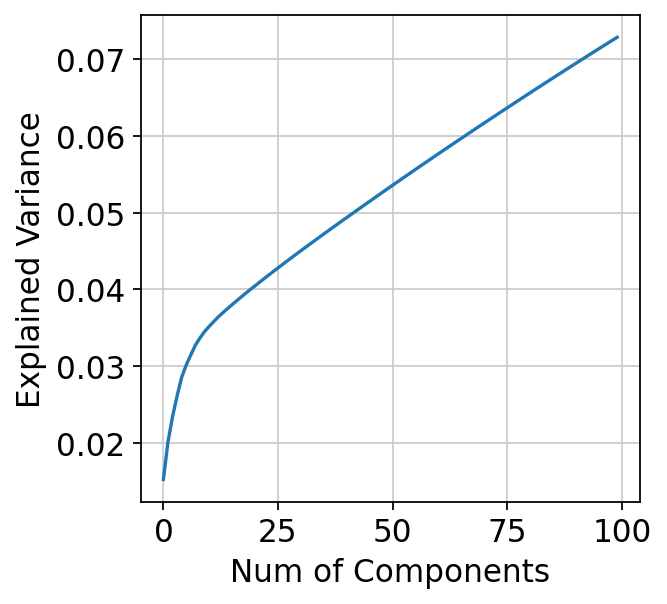

In [ ]:
plt.plot(np.cumsum(pca_100.explained_variance_ratio_))
plt.xlabel('Num of Components')
plt.ylabel('Explained Variance')
plt.show()

In [ ]:
pca_1000 = PCA(n_components=1000)
pca_X1 = pca_1000.fit_transform(sn_adata.X) #sort of like the training dimensions
pca_X2 = pca_1000.transform(sc_adata.X)  #fitting sc into sn dimensions
pca_X2

array([[ -3.3837426 ,   2.297367  ,  10.286774  , ...,   1.4188087 ,
         -0.99771535,   0.06333871],
       [-16.59885   , -11.018894  ,  -7.326252  , ...,  -0.2298077 ,
          0.22100928,  -0.14246124],
       [  3.7667062 ,   7.176072  ,  18.752748  , ...,   0.24099213,
         -0.54346967,  -1.2418355 ],
       ...,
       [-13.62262   ,  -8.817809  ,  -6.0641565 , ...,   0.17327508,
         -0.46197745,  -0.03147342],
       [-19.757252  ,  -9.289207  , -10.817515  , ...,   0.35963216,
          0.27972   ,   0.16253902],
       [ -6.2927017 ,  -8.177662  ,  -9.303891  , ...,   0.03546441,
          0.14252406,  -0.59623766]], dtype=float32)

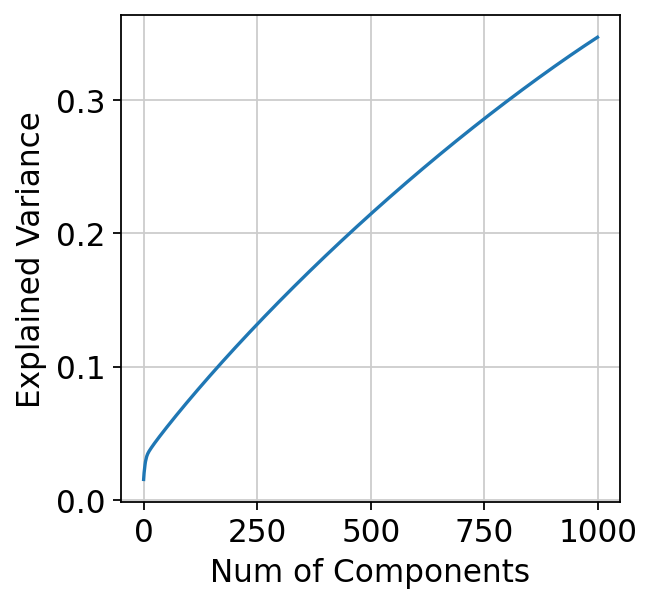

In [ ]:
plt.plot(np.cumsum(pca_1000.explained_variance_ratio_))
plt.xlabel('Num of Components')
plt.ylabel('Explained Variance')
plt.show()

In [ ]:
pca_095 = PCA(n_components=0.95)
pca_X1 = pca_095.fit_transform(sn_adata.X) #sort of like the training dimensions
pca_X2 = pca_095.transform(sc_adata.X)  #fitting sc into sn dimensions
pca_X2

array([[-3.3837473e+00,  2.2973545e+00,  1.0286746e+01, ...,
         6.7381221e-01,  1.4160386e+00, -1.3537028e+00],
       [-1.6598845e+01, -1.1018909e+01, -7.3262510e+00, ...,
        -6.4226997e-01,  1.1660457e-03, -4.1061521e-01],
       [ 3.7667015e+00,  7.1760678e+00,  1.8752764e+01, ...,
        -1.0307285e+00, -2.3528924e+00, -1.9470323e+00],
       ...,
       [-1.3622617e+01, -8.8178186e+00, -6.0641475e+00, ...,
         1.0420792e-01,  2.3048994e-01, -7.8630525e-01],
       [-1.9757246e+01, -9.2892237e+00, -1.0817528e+01, ...,
         5.4506087e-01,  1.9807941e-01, -3.2920268e-01],
       [-6.2926941e+00, -8.1776628e+00, -9.3038721e+00, ...,
         3.0712187e-01,  7.6636231e-01, -5.4683644e-01]], dtype=float32)

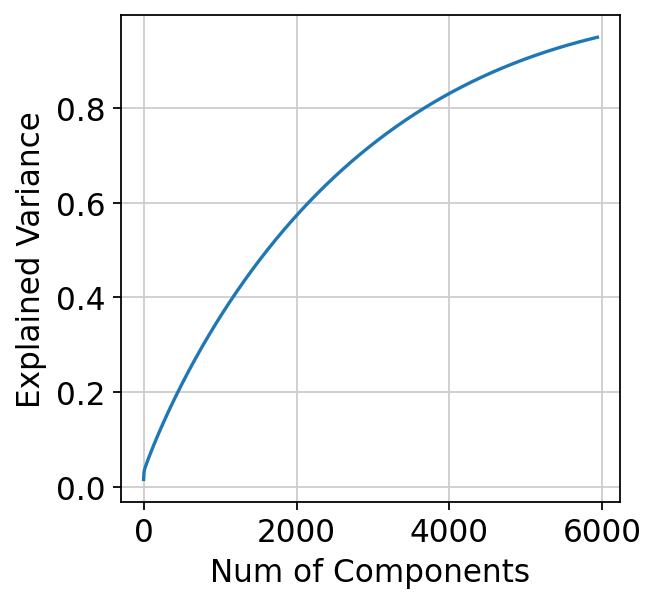

In [ ]:
plt.plot(np.cumsum(pca_095.explained_variance_ratio_))
plt.xlabel('Num of Components')
plt.ylabel('Explained Variance')
plt.show()